In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('traffic.csv')

# Inspect the first few rows to verify column names and structure
print(df.head())
print("Data shape:", df.shape)


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
Data shape: (48120, 4)


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('traffic.csv')

# Inspect the first few rows to verify column names and structure
print(df.head())
print("Data shape:", df.shape)


              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
Data shape: (48120, 4)


In [3]:
# Assuming that the dataset has a column named 'junction'.
# If the column name is different (e.g., 'Junction'), adjust accordingly.
df_junction1 = df[df['Junction'] == 1].reset_index(drop=True)
print("Filtered data shape (junction 1 only):", df_junction1.shape)


Filtered data shape (junction 1 only): (14592, 4)


In [4]:
import numpy as np

# Load the indices from the saved text files
train_idx = np.loadtxt("train_order_idx.txt", dtype=int)
val_idx   = np.loadtxt("val_order_idx.txt", dtype=int)
test_idx  = np.loadtxt("test_order_idx.txt", dtype=int)

# Re-create the training, validation, and test DataFrames from df_junction1
train_data = df_junction1.iloc[train_idx].reset_index(drop=True)
val_data   = df_junction1.iloc[val_idx].reset_index(drop=True)
test_data  = df_junction1.iloc[test_idx].reset_index(drop=True)

print("Train, Val, and Test sets created:")
print(" - Train data shape:", train_data.shape)
print(" - Validation data shape:", val_data.shape)
print(" - Test data shape:", test_data.shape)


Train, Val, and Test sets created:
 - Train data shape: (10214, 4)
 - Validation data shape: (1459, 4)
 - Test data shape: (2919, 4)


In [5]:
import pandas as pd

# Convert the DateTime column to datetime, if not already done
for d in [train_data, val_data, test_data]:
    d['DateTime'] = pd.to_datetime(d['DateTime'])

# Define the target column and feature columns
target_col = 'Vehicles'
# Remove target and DateTime columns from features list
feature_cols = [col for col in train_data.columns if col not in [target_col, 'DateTime']]

# Separate features and target for each split
X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_val = val_data[feature_cols]
y_val = val_data[target_col]

X_test = test_data[feature_cols]
y_test = test_data[target_col]

# No scaling at this stage - we'll handle specific scaling later
print("Features and targets separated without scaling.")

Features and targets separated without scaling.



Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Device name: NVIDIA GeForce GTX 1050 Ti


c:\Users\PLN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting PatchTST training...
  -> Validation loss improved to 0.170935. Saving model.
Epoch 1/50 - Train Loss: 0.239525 - Val Loss: 0.170935 - Time: 7.90s
  -> Validation loss improved to 0.127585. Saving model.
Epoch 2/50 - Train Loss: 0.073444 - Val Loss: 0.127585 - Time: 6.17s
Epoch 3/50 - Train Loss: 0.062116 - Val Loss: 0.135706 - Time: 6.11s
  -> Validation loss improved to 0.121429. Saving model.
Epoch 4/50 - Train Loss: 0.059313 - Val Loss: 0.121429 - Time: 6.12s
  -> Validation loss improved to 0.110279. Saving model.
Epoch 5/50 - Train Loss: 0.056316 - Val Loss: 0.110279 - Time: 6.11s
Epoch 6/50 - Train Loss: 0.057049 - Val Loss: 0.113684 - Time: 6.16s
Epoch 7/50 - Train Loss: 0.053128 - Val Loss: 0.111507 - Time: 6.10s
Epoch 8/50 - Train Loss: 0.054085 - Val Loss: 0.110337 - Time: 6.11s
  -> Validation loss improved to 0.103979. Saving model.
Epoch 9/50 - Train Loss: 0.051868 - Val Loss: 0.103979 - Time: 6.13s
Epoch 10/50 - Train Loss: 0.050523 - Val Loss: 0.104817 - Time: 

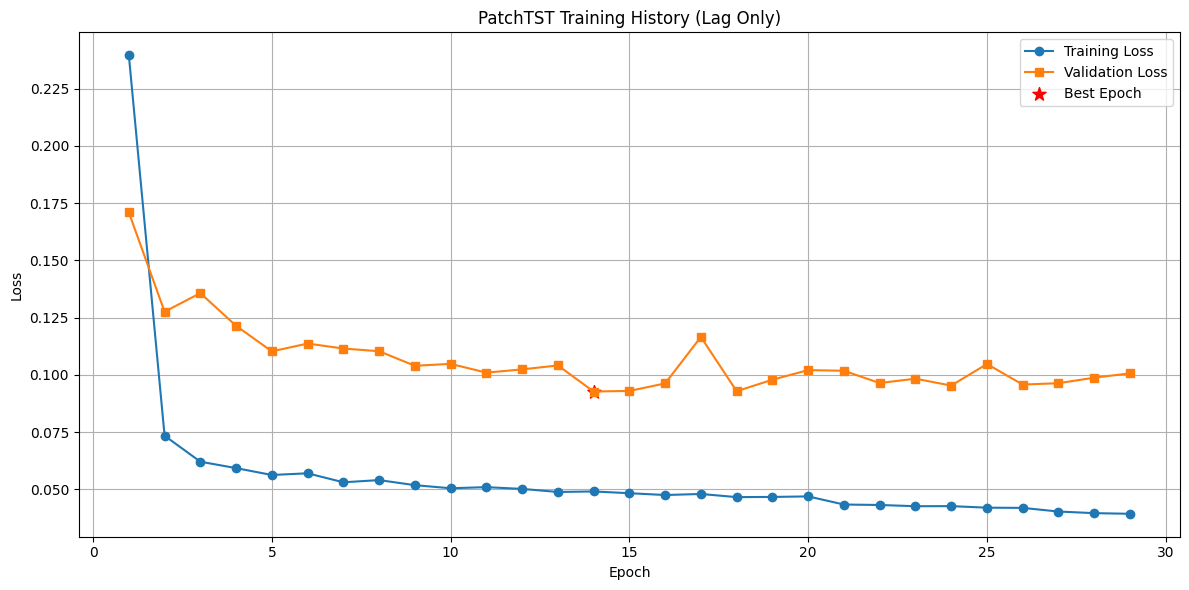


Loading best model from PatchTST_lag_only_model for evaluation...
Best model loaded successfully.


In [6]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from transformers import PatchTSTConfig, PatchTSTForPrediction
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available. Using CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Enhanced temporal features (Function kept for sorting, but features not used as input) ===
def extract_enhanced_datetime_features(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['hour'] = df['DateTime'].dt.hour
    df['day_of_week'] = df['DateTime'].dt.dayofweek
    df['day'] = df['DateTime'].dt.day
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_workday'] = (~df['is_weekend']).astype(int)
    df['morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['evening_rush'] = ((df['hour'] >= 16) & (df['hour'] <= 19)).astype(int)
    df['is_rush_hour'] = ((df['morning_rush'] | df['evening_rush']) & df['is_workday']).astype(int)
    return df

context_length = 168
prediction_length = 1

train_data_sorted = extract_enhanced_datetime_features(train_data.sort_values('DateTime').reset_index(drop=True))
val_data_sorted = extract_enhanced_datetime_features(val_data.sort_values('DateTime').reset_index(drop=True))
test_data_sorted = extract_enhanced_datetime_features(test_data.sort_values('DateTime').reset_index(drop=True))

scaler = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(train_data_sorted)))
scaler.fit(train_data_sorted['Vehicles'].values.reshape(-1, 1))

train_scaled = scaler.transform(train_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()
val_scaled = scaler.transform(val_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_data_sorted['Vehicles'].values.reshape(-1, 1)).flatten()

def prepare_transformer_data(values, context_length, prediction_length):
    past_values, future_values, past_observed_mask = [], [], []
    total_len_needed = context_length + prediction_length
    for i in range(len(values) - total_len_needed + 1):
        past_values.append(values[i : i + context_length])
        future_values.append(values[i + context_length : i + total_len_needed])
        past_observed_mask.append(np.ones(context_length, dtype=bool))
    return (
        np.array(past_values),
        np.array(past_observed_mask),
        np.array(future_values)
    )

train_past_vals, train_mask, train_future_vals = prepare_transformer_data(
    train_scaled, context_length, prediction_length
)
val_past_vals, val_mask, val_future_vals = prepare_transformer_data(
    val_scaled, context_length, prediction_length
)
test_past_vals, test_mask, test_future_vals = prepare_transformer_data(
    test_scaled, context_length, prediction_length
)

# PatchTST expects past_values in shape [batch_size, seq_length, num_input_channels]
train_past_values_tensor = torch.tensor(train_past_vals, dtype=torch.float32).unsqueeze(-1).to(device)
train_future_values_tensor = torch.tensor(train_future_vals, dtype=torch.float32).unsqueeze(-1).to(device)
train_observed_mask_tensor = torch.tensor(train_mask, dtype=torch.bool).unsqueeze(-1).to(device)

val_past_values_tensor = torch.tensor(val_past_vals, dtype=torch.float32).unsqueeze(-1).to(device)
val_future_values_tensor = torch.tensor(val_future_vals, dtype=torch.float32).unsqueeze(-1).to(device)
val_observed_mask_tensor = torch.tensor(val_mask, dtype=torch.bool).unsqueeze(-1).to(device)

test_past_values_tensor = torch.tensor(test_past_vals, dtype=torch.float32).unsqueeze(-1).to(device)
test_future_values_tensor = torch.tensor(test_future_vals, dtype=torch.float32).unsqueeze(-1).to(device)
test_observed_mask_tensor = torch.tensor(test_mask, dtype=torch.bool).unsqueeze(-1).to(device)

train_dataset = TensorDataset(train_past_values_tensor, train_observed_mask_tensor, train_future_values_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# === PatchTST Config ===
config = PatchTSTConfig(
    context_length=context_length,
    prediction_length=prediction_length,
    patch_length=12,
    patch_stride=12,
    num_input_channels=1,
    d_model=256,
    num_hidden_layers=8,
    num_attention_heads=4,
    ffn_dim=512,
    dropout=0.2,
    norm_type="layernorm",
    scaling="std",
    loss="mse",
    head_dropout=0.2
)

model = PatchTSTForPrediction(config).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print("Starting PatchTST training...")
best_val_loss = float('inf')
patience = 15
patience_counter = 0
epochs = 50
train_losses, val_losses, epoch_times = [], [], []
model_name = "PatchTST_lag_only_model"

for epoch in range(epochs):
    model.train()
    epoch_start = time.time()
    epoch_loss = 0

    for past_batch, mask_batch, future_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(
            past_values=past_batch,
            past_observed_mask=mask_batch,
            future_values=future_batch
        )
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item() * past_batch.size(0)

    avg_train_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(
            past_values=val_past_values_tensor,
            past_observed_mask=val_observed_mask_tensor,
            future_values=val_future_values_tensor
        )
        val_loss = val_outputs.loss.item()
        val_losses.append(val_loss)

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_pretrained(model_name)
        print(f"  -> Validation loss improved to {best_val_loss:.6f}. Saving model.")
        patience_counter = 0
    else:
        patience_counter += 1

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f} - Time: {epoch_time:.2f}s")

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print(f"\nTraining completed in {len(train_losses)} epochs")
if val_losses:
    best_epoch_idx = val_losses.index(min(val_losses))
    print(f"Best validation loss: {min(val_losses):.6f} at epoch {best_epoch_idx + 1}")
    print(f"Final validation loss: {val_losses[-1]:.6f}")
else:
    print("No validation losses recorded.")

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', marker='o')
if val_losses:
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker='s')
    if 'best_epoch_idx' in locals():
        plt.scatter(best_epoch_idx + 1, min(val_losses), c='red', s=100, label='Best Epoch', marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PatchTST Training History (Lag Only)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nLoading best model from {model_name} for evaluation...")
import os
if os.path.exists(model_name):
    model = PatchTSTForPrediction.from_pretrained(model_name).to(device)
    print("Best model loaded successfully.")
else:
    print(f"Warning: Model directory '{model_name}' not found. Using model from the last training epoch.")

Loaded best model from PatchTST_lag_only_model for evaluation.
Generating predictions on the test set using forward pass...
Shape of scaled predictions: (2751,)
Shape of original predictions: (2751,)
Shape of original targets: (2751,)

PatchTST Test RMSE: 5.21
PatchTST Test MAE: 3.88


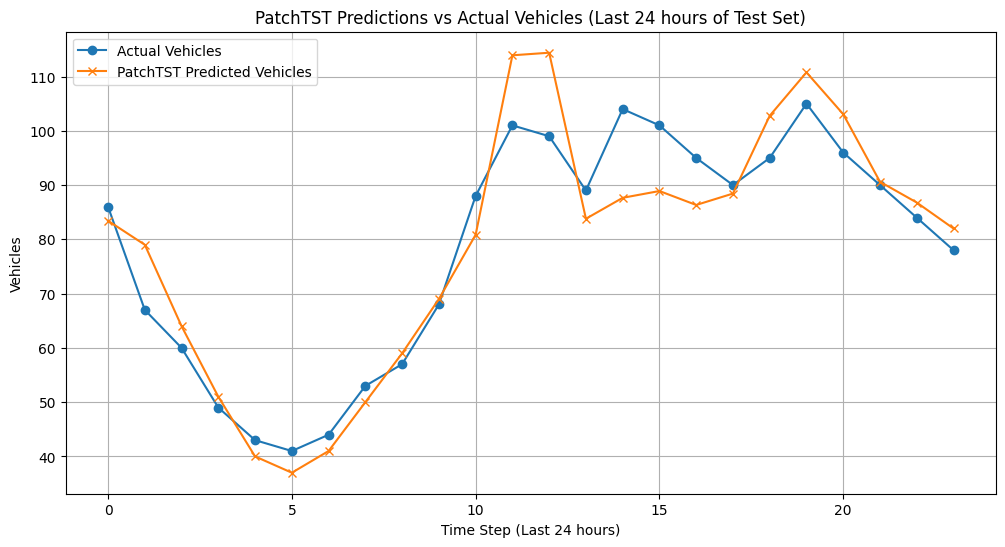

In [7]:
# === Evaluate PatchTST Model ===
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os

# Ensure the best model is loaded (or use the last trained one if save failed)
model_name = "PatchTST_lag_only_model"
if os.path.exists(model_name):
    model = PatchTSTForPrediction.from_pretrained(model_name).to(device)
    print(f"Loaded best model from {model_name} for evaluation.")
else:
    print(f"Warning: Model directory '{model_name}' not found. Using model from the last training epoch for evaluation.")
    model.to(device)

# Set model to evaluation mode
model.eval()

# Store predictions
all_preds_scaled = []

# Predict on the test set using standard forward pass
with torch.no_grad():
    # PatchTST expects mask as past_observed_mask
    test_dataset_eval = TensorDataset(test_past_values_tensor, test_observed_mask_tensor)
    test_loader_eval = DataLoader(test_dataset_eval, batch_size=128, shuffle=False)

    print("Generating predictions on the test set using forward pass...")
    for past_batch, mask_batch in test_loader_eval:
        outputs = model(
            past_values=past_batch,
            past_observed_mask=mask_batch
            # No future_values needed for prediction
        )
        # Shape is [batch_size, prediction_length, num_input_channels]
        preds = outputs.prediction_outputs.squeeze().cpu().numpy()
        all_preds_scaled.append(preds)

# Concatenate predictions from all batches
patchtst_test_pred_scaled = np.concatenate(all_preds_scaled)

# Ensure it's a 1D array if prediction_length was 1
if patchtst_test_pred_scaled.ndim > 1 and patchtst_test_pred_scaled.shape[1] == 1:
    patchtst_test_pred_scaled = patchtst_test_pred_scaled.flatten()
elif patchtst_test_pred_scaled.ndim == 0:
    patchtst_test_pred_scaled = np.array([patchtst_test_pred_scaled.item()])
elif patchtst_test_pred_scaled.ndim != 1:
    print(f"Warning: Unexpected prediction shape after concatenation: {patchtst_test_pred_scaled.shape}. Attempting to flatten.")
    patchtst_test_pred_scaled = patchtst_test_pred_scaled.flatten()

print(f"Shape of scaled predictions: {patchtst_test_pred_scaled.shape}")

# Inverse transform the predictions to get the original scale
patchtst_test_pred_orig = scaler.inverse_transform(patchtst_test_pred_scaled.reshape(-1, 1)).flatten()
patchtst_test_pred_orig = np.clip(patchtst_test_pred_orig, 0, None) # Ensure non-negative predictions

# Get the original actual test targets corresponding to the predictions
y_test_orig = scaler.inverse_transform(test_future_vals.reshape(-1, 1)).flatten()
y_test_orig = np.clip(y_test_orig, 0, None) # Ensure non-negative targets

print(f"Shape of original predictions: {patchtst_test_pred_orig.shape}")
print(f"Shape of original targets: {y_test_orig.shape}")

# Ensure predictions and targets have the same length
min_len = min(len(patchtst_test_pred_orig), len(y_test_orig))
if len(patchtst_test_pred_orig) != len(y_test_orig):
    print(f"Warning: Mismatch in prediction ({len(patchtst_test_pred_orig)}) and target ({len(y_test_orig)}) lengths. Trimming to {min_len}.")
patchtst_test_pred_orig = patchtst_test_pred_orig[:min_len]
y_test_orig = y_test_orig[:min_len]

# Calculate RMSE and MAE for PatchTST predictions
if min_len > 0:
    patchtst_rmse = np.sqrt(mean_squared_error(y_test_orig, patchtst_test_pred_orig))
    patchtst_mae = mean_absolute_error(y_test_orig, patchtst_test_pred_orig)

    print(f"\nPatchTST Test RMSE: {patchtst_rmse:.2f}")
    print(f"PatchTST Test MAE: {patchtst_mae:.2f}")

    # Plot PatchTST predictions vs actuals for the last 24 hours of the test set
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_orig[-24:], label='Actual Vehicles', marker='o')
    plt.plot(patchtst_test_pred_orig[-24:], label='PatchTST Predicted Vehicles', marker='x')
    plt.title('PatchTST Predictions vs Actual Vehicles (Last 24 hours of Test Set)')
    plt.xlabel('Time Step (Last 24 hours)')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nCannot calculate metrics or plot: No matching predictions and targets found after alignment.")

In [10]:
# === Generate PatchTST Predictions for Train/Val (Needed for Refinement) ===
print("Generating PatchTST predictions for Train and Validation sets...")

# Ensure model is loaded and in eval mode
model.eval()

# --- Generate Train Predictions ---
all_train_preds_scaled = []
with torch.no_grad():
    train_dataset_eval = TensorDataset(train_past_values_tensor, train_observed_mask_tensor)
    train_loader_eval = DataLoader(train_dataset_eval, batch_size=128, shuffle=False)

    for past_batch, mask_batch in train_loader_eval:
         outputs = model(past_values=past_batch, past_observed_mask=mask_batch)
         preds = outputs.prediction_outputs.squeeze().cpu().numpy()
         if preds.ndim == 0:
             preds = np.array([preds.item()])
         all_train_preds_scaled.append(preds)

patchtst_train_pred_scaled = np.concatenate(all_train_preds_scaled)
if patchtst_train_pred_scaled.ndim != 1:
     patchtst_train_pred_scaled = patchtst_train_pred_scaled.flatten()

# --- Generate Validation Predictions ---
all_val_preds_scaled = []
with torch.no_grad():
    val_dataset_eval = TensorDataset(val_past_values_tensor, val_observed_mask_tensor)
    val_loader_eval = DataLoader(val_dataset_eval, batch_size=128, shuffle=False)

    for past_batch, mask_batch in val_loader_eval:
         outputs = model(past_values=past_batch, past_observed_mask=mask_batch)
         preds = outputs.prediction_outputs.squeeze().cpu().numpy()
         if preds.ndim == 0:
             preds = np.array([preds.item()])
         all_val_preds_scaled.append(preds)

patchtst_val_pred_scaled = np.concatenate(all_val_preds_scaled)
if patchtst_val_pred_scaled.ndim != 1:
     patchtst_val_pred_scaled = patchtst_val_pred_scaled.flatten()

print(f"PatchTST Train Pred Scaled Shape: {patchtst_train_pred_scaled.shape}")
print(f"PatchTST Val Pred Scaled Shape: {patchtst_val_pred_scaled.shape}")
# Note: patchtst_test_pred_scaled is assumed to exist from the previous cell

# --- Define Temporal Features List (based on extract_enhanced_datetime_features) ---
temporal_features = [
    'hour', 'day_of_week', 'day', 'month', 'year',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos', 'is_weekend', 'is_workday',
    'morning_rush', 'evening_rush', 'is_rush_hour'
]

# --- Extract Temporal Features from Sorted DataFrames ---
# The prepare_transformer_data function creates sequences, effectively shortening
# the usable length by (context_length + prediction_length - 1).
# We need to align the temporal features with the *start* of the prediction window
# for each sequence generated by prepare_transformer_data.
offset = context_length + prediction_length - 1

# Align temporal features: Take features starting from the offset index
# This ensures temporal features correspond to the time step being predicted (t+1)
# relative to the context window ending at t.
train_temporal = train_data_sorted[temporal_features].iloc[offset:].values
val_temporal = val_data_sorted[temporal_features].iloc[offset:].values
test_temporal = test_data_sorted[temporal_features].iloc[offset:].values

# --- Align Scaled Targets (from cell 1ec2bdb3, used for future_values) ---
# These are the actual values corresponding to the predictions
y_train_scaled_aligned = train_scaled[offset:]
y_val_scaled_aligned = val_scaled[offset:]
y_test_scaled_aligned = test_scaled[offset:] # Corresponds to test_future_vals

# --- Align Original Test Targets (y_test_orig from previous cell) ---
# y_test_orig was already aligned with test_future_vals in the previous cell
y_test_orig_aligned = y_test_orig # Use the aligned version from previous cell

# --- Final Check and Alignment of Shapes ---
# Ensure train predictions match train targets/temporal features
min_len_train = min(len(patchtst_train_pred_scaled), len(y_train_scaled_aligned), len(train_temporal))
if len(patchtst_train_pred_scaled) != min_len_train or len(y_train_scaled_aligned) != min_len_train or len(train_temporal) != min_len_train:
    print(f"Aligning Train Data to minimum length: {min_len_train}")
    patchtst_train_pred_scaled = patchtst_train_pred_scaled[:min_len_train]
    y_train_scaled_aligned = y_train_scaled_aligned[:min_len_train]
    train_temporal = train_temporal[:min_len_train]

# Ensure val predictions match val targets/temporal features
min_len_val = min(len(patchtst_val_pred_scaled), len(y_val_scaled_aligned), len(val_temporal))
if len(patchtst_val_pred_scaled) != min_len_val or len(y_val_scaled_aligned) != min_len_val or len(val_temporal) != min_len_val:
    print(f"Aligning Validation Data to minimum length: {min_len_val}")
    patchtst_val_pred_scaled = patchtst_val_pred_scaled[:min_len_val]
    y_val_scaled_aligned = y_val_scaled_aligned[:min_len_val]
    val_temporal = val_temporal[:min_len_val]

# Ensure test predictions match test targets/temporal features
min_len_test = min(len(patchtst_test_pred_scaled), len(y_test_scaled_aligned), len(test_temporal), len(y_test_orig_aligned))
if len(patchtst_test_pred_scaled) != min_len_test or len(y_test_scaled_aligned) != min_len_test or len(test_temporal) != min_len_test or len(y_test_orig_aligned) != min_len_test:
    print(f"Aligning Test Data to minimum length: {min_len_test}")
    patchtst_test_pred_scaled = patchtst_test_pred_scaled[:min_len_test]
    y_test_scaled_aligned = y_test_scaled_aligned[:min_len_test]
    test_temporal = test_temporal[:min_len_test]
    y_test_orig_aligned = y_test_orig_aligned[:min_len_test]


print("\n--- Aligned Shapes for Refinement ---")
print(f"Train Preds: {patchtst_train_pred_scaled.shape}, Train Targets: {y_train_scaled_aligned.shape}, Train Temporal: {train_temporal.shape}")
print(f"Val Preds: {patchtst_val_pred_scaled.shape}, Val Targets: {y_val_scaled_aligned.shape}, Val Temporal: {val_temporal.shape}")
print(f"Test Preds: {patchtst_test_pred_scaled.shape}, Test Targets: {y_test_scaled_aligned.shape}, Test Temporal: {test_temporal.shape}, Test Orig Targets: {y_test_orig_aligned.shape}")

print("\nVariables ready for XGBoost refinement using PatchTST predictions.")


Generating PatchTST predictions for Train and Validation sets...
PatchTST Train Pred Scaled Shape: (10046,)
PatchTST Val Pred Scaled Shape: (1291,)

--- Aligned Shapes for Refinement ---
Train Preds: (10046,), Train Targets: (10046,), Train Temporal: (10046, 16)
Val Preds: (1291,), Val Targets: (1291,), Val Temporal: (1291, 16)
Test Preds: (2751,), Test Targets: (2751,), Test Temporal: (2751, 16), Test Orig Targets: (2751,)

Variables ready for XGBoost refinement using PatchTST predictions.


[I 2025-05-20 16:05:46,099] A new study created in memory with name: no-name-2bb7b220-9a6b-4cf5-bcb6-e5942622e4b7


--- Optimizing Refinement Model (XGBoost with Optuna using PatchTST Preds) ---
Cleared PyTorch CUDA cache.
Calculated residuals for XGBoost target using PatchTST predictions.
Adding interaction features...
Total refinement features: 21
Shapes being used for XGBoost:
Train X: (10046, 21), Train y: (10046,)
Val X: (1291, 21), Val y: (1291,)
Test X: (2751, 21), Test y: (2751,)
Starting Optuna optimization for XGBoost...

--- Starting Trial 0 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 5.386730730568466e-05, 'alpha': 0.0007060594583508163, 'subsample': 0.8132691454279471, 'colsample_bytree': 0.46037185920626045, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 12, 'min_child_weight': 24, 'eta': 0.0005307524838254154, 'gamma': 0.1142052740082942, 'grow_policy': 'depthwise'} ---
[0]	validation-rmse:0.30480
[99]	validation-rmse:0.30445


[I 2025-05-20 16:05:48,568] Trial 0 finished with value: 0.30445285081915224 and parameters: {'booster': 'gbtree', 'lambda': 5.386730730568466e-05, 'alpha': 0.0007060594583508163, 'subsample': 0.8132691454279471, 'colsample_bytree': 0.46037185920626045, 'max_depth': 12, 'min_child_weight': 24, 'eta': 0.0005307524838254154, 'gamma': 0.1142052740082942, 'grow_policy': 'depthwise', 'num_boost_round': 100}. Best is trial 0 with value: 0.30445285081915224.


--- Trial 0 finished successfully (best_score=0.304453) ---
Callback: Trial 0 finished with value (Residual RMSE): 0.304453. Best is trial 0 with value: 0.304453.

--- Starting Trial 1 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.0002568397505189977, 'alpha': 0.8587696499189246, 'subsample': 0.7485283967909262, 'colsample_bytree': 0.4915135229826201, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.004162737795641363, 'gamma': 8.736119132959499e-08, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.30478
[100]	validation-rmse:0.30289
[200]	validation-rmse:0.30211
[300]	validation-rmse:0.30166
[400]	validation-rmse:0.30127
[500]	validation-rmse:0.30105
[600]	validation-rmse:0.30090
[700]	validation-rmse:0.30080
[757]	validation-rmse:0.30090


[I 2025-05-20 16:06:05,711] Trial 1 finished with value: 0.30075230872615094 and parameters: {'booster': 'gbtree', 'lambda': 0.0002568397505189977, 'alpha': 0.8587696499189246, 'subsample': 0.7485283967909262, 'colsample_bytree': 0.4915135229826201, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.004162737795641363, 'gamma': 8.736119132959499e-08, 'grow_policy': 'lossguide', 'num_boost_round': 1800}. Best is trial 1 with value: 0.30075230872615094.


--- Trial 1 finished successfully (best_score=0.300752) ---
Callback: Trial 1 finished with value (Residual RMSE): 0.300752. Best is trial 1 with value: 0.300752.

--- Starting Trial 2 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 5.7979348213685285e-05, 'alpha': 0.02945719749602597, 'subsample': 0.9489987389608225, 'colsample_bytree': 0.8473274777020888, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 11, 'min_child_weight': 23, 'eta': 0.12777973097329695, 'gamma': 1.1323921241012748e-09, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.30483
[62]	validation-rmse:0.31137


[I 2025-05-20 16:06:06,959] Trial 2 finished with value: 0.30201998215776016 and parameters: {'booster': 'gbtree', 'lambda': 5.7979348213685285e-05, 'alpha': 0.02945719749602597, 'subsample': 0.9489987389608225, 'colsample_bytree': 0.8473274777020888, 'max_depth': 11, 'min_child_weight': 23, 'eta': 0.12777973097329695, 'gamma': 1.1323921241012748e-09, 'grow_policy': 'lossguide', 'num_boost_round': 700}. Best is trial 1 with value: 0.30075230872615094.


--- Trial 2 finished successfully (best_score=0.302020) ---
Callback: Trial 2 finished with value (Residual RMSE): 0.302020. Best is trial 1 with value: 0.300752.

--- Starting Trial 3 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.020576244592009726, 'alpha': 0.0004315626443757194, 'subsample': 0.448619886920551, 'colsample_bytree': 0.7668180368977779, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.11639346119974246, 'gamma': 0.013010960626516103, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.30449
[56]	validation-rmse:0.30709


[I 2025-05-20 16:06:07,384] Trial 3 finished with value: 0.30300373401973113 and parameters: {'booster': 'gbtree', 'lambda': 0.020576244592009726, 'alpha': 0.0004315626443757194, 'subsample': 0.448619886920551, 'colsample_bytree': 0.7668180368977779, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.11639346119974246, 'gamma': 0.013010960626516103, 'grow_policy': 'lossguide', 'num_boost_round': 1800}. Best is trial 1 with value: 0.30075230872615094.


--- Trial 3 finished successfully (best_score=0.303004) ---
Callback: Trial 3 finished with value (Residual RMSE): 0.303004. Best is trial 1 with value: 0.300752.

--- Starting Trial 4 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 1.770360457258162, 'alpha': 17.586391340474776, 'subsample': 0.5422502144134309, 'colsample_bytree': 0.7236837882051077, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 12, 'min_child_weight': 13, 'eta': 0.015682867692502784, 'gamma': 0.007140034961618731, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.30478
[100]	validation-rmse:0.30339
[200]	validation-rmse:0.30295
[300]	validation-rmse:0.30268
[399]	validation-rmse:0.30260


[I 2025-05-20 16:06:10,805] Trial 4 finished with value: 0.30258287708190773 and parameters: {'booster': 'gbtree', 'lambda': 1.770360457258162, 'alpha': 17.586391340474776, 'subsample': 0.5422502144134309, 'colsample_bytree': 0.7236837882051077, 'max_depth': 12, 'min_child_weight': 13, 'eta': 0.015682867692502784, 'gamma': 0.007140034961618731, 'grow_policy': 'lossguide', 'num_boost_round': 400}. Best is trial 1 with value: 0.30075230872615094.


--- Trial 4 finished successfully (best_score=0.302583) ---
Callback: Trial 4 finished with value (Residual RMSE): 0.302583. Best is trial 1 with value: 0.300752.

--- Starting Trial 5 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 0.09493506163835852, 'alpha': 0.0021818906967356437, 'subsample': 0.5120976537071715, 'colsample_bytree': 0.7586692813962259, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 12, 'min_child_weight': 22, 'eta': 0.00589358585027622, 'gamma': 5.397494221440947e-05, 'grow_policy': 'lossguide'} ---
[0]	validation-rmse:0.30478
[100]	validation-rmse:0.30235
[200]	validation-rmse:0.30130
[256]	validation-rmse:0.30139


[I 2025-05-20 16:06:18,864] Trial 5 finished with value: 0.30122976181369715 and parameters: {'booster': 'gbtree', 'lambda': 0.09493506163835852, 'alpha': 0.0021818906967356437, 'subsample': 0.5120976537071715, 'colsample_bytree': 0.7586692813962259, 'max_depth': 12, 'min_child_weight': 22, 'eta': 0.00589358585027622, 'gamma': 5.397494221440947e-05, 'grow_policy': 'lossguide', 'num_boost_round': 900}. Best is trial 1 with value: 0.30075230872615094.


--- Trial 5 finished successfully (best_score=0.301230) ---
Callback: Trial 5 finished with value (Residual RMSE): 0.301230. Best is trial 1 with value: 0.300752.

--- Starting Trial 6 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'lambda': 1.0021010339051395, 'alpha': 0.03122890303533594, 'subsample': 0.4143790658290146, 'colsample_bytree': 0.7143658873586837, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 4, 'min_child_weight': 19, 'eta': 0.0005556993380080797, 'gamma': 0.003250121772210608, 'grow_policy': 'depthwise'} ---
[0]	validation-rmse:0.30480
[100]	validation-rmse:0.30455
[200]	validation-rmse:0.30434
[300]	validation-rmse:0.30415
[400]	validation-rmse:0.30396
[500]	validation-rmse:0.30379
[600]	validation-rmse:0.30365
[700]	validation-rmse:0.30353
[800]	validation-rmse:0.30343
[900]	validation-rmse:0.30331
[1000]	validation-rmse:0.30325
[1100]	validation-rmse:0.30317
[1200]	validation-rmse:

[I 2025-05-20 16:06:22,672] Trial 6 finished with value: 0.30298166241722124 and parameters: {'booster': 'gbtree', 'lambda': 1.0021010339051395, 'alpha': 0.03122890303533594, 'subsample': 0.4143790658290146, 'colsample_bytree': 0.7143658873586837, 'max_depth': 4, 'min_child_weight': 19, 'eta': 0.0005556993380080797, 'gamma': 0.003250121772210608, 'grow_policy': 'depthwise', 'num_boost_round': 1400}. Best is trial 1 with value: 0.30075230872615094.


--- Trial 6 finished successfully (best_score=0.302982) ---
Callback: Trial 6 finished with value (Residual RMSE): 0.302982. Best is trial 1 with value: 0.300752.

--- Starting Trial 7 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.44673561171528303, 'alpha': 0.02328687483104673, 'subsample': 0.8433112245964306, 'colsample_bytree': 0.45969683889085344, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 11, 'eta': 0.030767449167201817, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.8141939895843e-06, 'skip_drop': 1.7352997086807808e-07} ---
[0]	validation-rmse:0.30440
[95]	validation-rmse:0.30202


[I 2025-05-20 16:06:29,281] Trial 7 finished with value: 0.29977436847459227 and parameters: {'booster': 'dart', 'lambda': 0.44673561171528303, 'alpha': 0.02328687483104673, 'subsample': 0.8433112245964306, 'colsample_bytree': 0.45969683889085344, 'max_depth_dart': 11, 'eta_dart': 0.030767449167201817, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.8141939895843e-06, 'skip_drop': 1.7352997086807808e-07, 'num_boost_round': 1900}. Best is trial 7 with value: 0.29977436847459227.


--- Trial 7 finished successfully (best_score=0.299774) ---
Callback: Trial 7 finished with value (Residual RMSE): 0.299774. Best is trial 7 with value: 0.299774.

--- Starting Trial 8 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 5.961467073540592e-05, 'alpha': 0.001166029069871951, 'subsample': 0.597636170457526, 'colsample_bytree': 0.7271668593457734, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 11, 'eta': 0.03446625937191906, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0013188788868882045, 'skip_drop': 7.655421736815225e-08} ---
[0]	validation-rmse:0.30407
[67]	validation-rmse:0.30672


[I 2025-05-20 16:06:32,881] Trial 8 finished with value: 0.302118266666841 and parameters: {'booster': 'dart', 'lambda': 5.961467073540592e-05, 'alpha': 0.001166029069871951, 'subsample': 0.597636170457526, 'colsample_bytree': 0.7271668593457734, 'max_depth_dart': 11, 'eta_dart': 0.03446625937191906, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0013188788868882045, 'skip_drop': 7.655421736815225e-08, 'num_boost_round': 1900}. Best is trial 7 with value: 0.29977436847459227.


--- Trial 8 finished successfully (best_score=0.302118) ---
Callback: Trial 8 finished with value (Residual RMSE): 0.302118. Best is trial 7 with value: 0.299774.

--- Starting Trial 9 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.8972841093821685, 'alpha': 0.0004086357346787346, 'subsample': 0.5814288955399226, 'colsample_bytree': 0.9663669961888185, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 3, 'eta': 0.09683080863398094, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2476966997125017e-05, 'skip_drop': 2.599072593987761e-07} ---
[0]	validation-rmse:0.30448
[56]	validation-rmse:0.30578


[I 2025-05-20 16:06:34,656] Trial 9 finished with value: 0.30244364254802847 and parameters: {'booster': 'dart', 'lambda': 0.8972841093821685, 'alpha': 0.0004086357346787346, 'subsample': 0.5814288955399226, 'colsample_bytree': 0.9663669961888185, 'max_depth_dart': 3, 'eta_dart': 0.09683080863398094, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2476966997125017e-05, 'skip_drop': 2.599072593987761e-07, 'num_boost_round': 1600}. Best is trial 7 with value: 0.29977436847459227.


--- Trial 9 finished successfully (best_score=0.302444) ---
Callback: Trial 9 finished with value (Residual RMSE): 0.302444. Best is trial 7 with value: 0.299774.

--- Starting Trial 10 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.0025643233711832763, 'alpha': 1.1160128015781874e-05, 'subsample': 0.9742034098309356, 'colsample_bytree': 0.5786533436617626, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 12, 'eta': 0.0008311858677815678, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.405431657809827e-08, 'skip_drop': 0.45440882295974333} ---
[0]	validation-rmse:0.30478
[100]	validation-rmse:0.30356
[200]	validation-rmse:0.30245
[300]	validation-rmse:0.30162
[400]	validation-rmse:0.30102
[500]	validation-rmse:0.30061
[600]	validation-rmse:0.30043
[696]	validation-rmse:0.30036


[I 2025-05-20 16:11:30,918] Trial 10 finished with value: 0.3002992608018089 and parameters: {'booster': 'dart', 'lambda': 0.0025643233711832763, 'alpha': 1.1160128015781874e-05, 'subsample': 0.9742034098309356, 'colsample_bytree': 0.5786533436617626, 'max_depth_dart': 12, 'eta_dart': 0.0008311858677815678, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.405431657809827e-08, 'skip_drop': 0.45440882295974333, 'num_boost_round': 1300}. Best is trial 7 with value: 0.29977436847459227.


--- Trial 10 finished successfully (best_score=0.300299) ---
Callback: Trial 10 finished with value (Residual RMSE): 0.300299. Best is trial 7 with value: 0.299774.

--- Starting Trial 11 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.0016434923742413578, 'alpha': 0.35118777849537997, 'subsample': 0.9847777392306569, 'colsample_bytree': 0.5773586111874737, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 12, 'eta': 0.0006097996287231504, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0260289883566835e-08, 'skip_drop': 0.4448460574916383} ---
[0]	validation-rmse:0.30479
[100]	validation-rmse:0.30407
[200]	validation-rmse:0.30351
[300]	validation-rmse:0.30302
[400]	validation-rmse:0.30263
[500]	validation-rmse:0.30236
[600]	validation-rmse:0.30218
[700]	validation-rmse:0.30202
[800]	validation-rmse:0.30185
[900]	validation-rmse:0.30179
[1000]	validation-rmse:0.30174
[1031]	

[I 2025-05-20 16:20:12,254] Trial 11 finished with value: 0.3017327406469596 and parameters: {'booster': 'dart', 'lambda': 0.0016434923742413578, 'alpha': 0.35118777849537997, 'subsample': 0.9847777392306569, 'colsample_bytree': 0.5773586111874737, 'max_depth_dart': 12, 'eta_dart': 0.0006097996287231504, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0260289883566835e-08, 'skip_drop': 0.4448460574916383, 'num_boost_round': 1300}. Best is trial 7 with value: 0.29977436847459227.


--- Trial 11 finished successfully (best_score=0.301733) ---
Callback: Trial 11 finished with value (Residual RMSE): 0.301733. Best is trial 7 with value: 0.299774.

--- Starting Trial 12 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.003198999728121898, 'alpha': 3.401779370822806e-05, 'subsample': 0.8692078767908583, 'colsample_bytree': 0.5888329980480371, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 10, 'eta': 0.0018821750088682224, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4220009353286552e-07, 'skip_drop': 0.03409803753236324} ---
[0]	validation-rmse:0.30478
[100]	validation-rmse:0.30297
[200]	validation-rmse:0.30195
[300]	validation-rmse:0.30115
[400]	validation-rmse:0.30071
[489]	validation-rmse:0.30067
--- Trial 12 finished successfully (best_score=0.300544) ---

[I 2025-05-20 16:22:10,153] Trial 12 finished with value: 0.30054364467086614 and parameters: {'booster': 'dart', 'lambda': 0.003198999728121898, 'alpha': 3.401779370822806e-05, 'subsample': 0.8692078767908583, 'colsample_bytree': 0.5888329980480371, 'max_depth_dart': 10, 'eta_dart': 0.0018821750088682224, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4220009353286552e-07, 'skip_drop': 0.03409803753236324, 'num_boost_round': 1200}. Best is trial 7 with value: 0.29977436847459227.



Callback: Trial 12 finished with value (Residual RMSE): 0.300544. Best is trial 7 with value: 0.299774.

--- Starting Trial 13 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 11.8570584926807, 'alpha': 1.2898359956368481e-05, 'subsample': 0.8868886449458055, 'colsample_bytree': 0.4030889145071654, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 8, 'eta': 0.007575826357156923, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.7486664747384426e-06, 'skip_drop': 7.802835306495401e-05} ---
[0]	validation-rmse:0.30476
[100]	validation-rmse:0.30254
[200]	validation-rmse:0.30163
[300]	validation-rmse:0.30121
[400]	validation-rmse:0.30100
[462]	validation-rmse:0.30112


[I 2025-05-20 16:23:51,890] Trial 13 finished with value: 0.30090396461155366 and parameters: {'booster': 'dart', 'lambda': 11.8570584926807, 'alpha': 1.2898359956368481e-05, 'subsample': 0.8868886449458055, 'colsample_bytree': 0.4030889145071654, 'max_depth_dart': 8, 'eta_dart': 0.007575826357156923, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.7486664747384426e-06, 'skip_drop': 7.802835306495401e-05, 'num_boost_round': 1500}. Best is trial 7 with value: 0.29977436847459227.


--- Trial 13 finished successfully (best_score=0.300904) ---
Callback: Trial 13 finished with value (Residual RMSE): 0.300904. Best is trial 7 with value: 0.299774.

--- Starting Trial 14 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.06638003668414708, 'alpha': 0.18680269810142378, 'subsample': 0.7176513348958787, 'colsample_bytree': 0.6085936810441971, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 12, 'eta': 0.3187540995805521, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0773408748332955, 'skip_drop': 0.00012113669397034313} ---
[0]	validation-rmse:0.30271
[50]	validation-rmse:0.30935


[I 2025-05-20 16:23:54,683] Trial 14 finished with value: 0.3027137304204151 and parameters: {'booster': 'dart', 'lambda': 0.06638003668414708, 'alpha': 0.18680269810142378, 'subsample': 0.7176513348958787, 'colsample_bytree': 0.6085936810441971, 'max_depth_dart': 12, 'eta_dart': 0.3187540995805521, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0773408748332955, 'skip_drop': 0.00012113669397034313, 'num_boost_round': 2000}. Best is trial 7 with value: 0.29977436847459227.


--- Trial 14 finished successfully (best_score=0.302714) ---
Callback: Trial 14 finished with value (Residual RMSE): 0.302714. Best is trial 7 with value: 0.299774.

--- Starting Trial 15 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.0021911590125959024, 'alpha': 0.005570535482133587, 'subsample': 0.874299324427147, 'colsample_bytree': 0.5219056789410575, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 9, 'eta': 0.008646550707410577, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.207408905200206e-07, 'skip_drop': 2.860610536228713e-06} ---
[0]	validation-rmse:0.30461
[100]	validation-rmse:0.29988
[167]	validation-rmse:0.30011


[I 2025-05-20 16:24:09,999] Trial 15 finished with value: 0.29961714247701815 and parameters: {'booster': 'dart', 'lambda': 0.0021911590125959024, 'alpha': 0.005570535482133587, 'subsample': 0.874299324427147, 'colsample_bytree': 0.5219056789410575, 'max_depth_dart': 9, 'eta_dart': 0.008646550707410577, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.207408905200206e-07, 'skip_drop': 2.860610536228713e-06, 'num_boost_round': 1000}. Best is trial 15 with value: 0.29961714247701815.


--- Trial 15 finished successfully (best_score=0.299617) ---
Callback: Trial 15 finished with value (Residual RMSE): 0.299617. Best is trial 15 with value: 0.299617.

--- Starting Trial 16 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.17462312906511857, 'alpha': 0.0076021583234657, 'subsample': 0.7975092165120664, 'colsample_bytree': 0.4999211458902838, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 8, 'eta': 0.00798976389349295, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.766461273287789e-06, 'skip_drop': 1.7928051195281876e-06} ---
[0]	validation-rmse:0.30468
[100]	validation-rmse:0.30164
[167]	validation-rmse:0.30174


[I 2025-05-20 16:24:24,764] Trial 16 finished with value: 0.3013490227928444 and parameters: {'booster': 'dart', 'lambda': 0.17462312906511857, 'alpha': 0.0076021583234657, 'subsample': 0.7975092165120664, 'colsample_bytree': 0.4999211458902838, 'max_depth_dart': 8, 'eta_dart': 0.00798976389349295, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.766461273287789e-06, 'skip_drop': 1.7928051195281876e-06, 'num_boost_round': 900}. Best is trial 15 with value: 0.29961714247701815.


--- Trial 16 finished successfully (best_score=0.301349) ---
Callback: Trial 16 finished with value (Residual RMSE): 0.301349. Best is trial 15 with value: 0.299617.

--- Starting Trial 17 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 15.451331782666495, 'alpha': 2.653741709094213, 'subsample': 0.6509898036223499, 'colsample_bytree': 0.4059469371777205, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 9, 'eta': 0.02130399994778157, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0002836466782201477, 'skip_drop': 4.3673761592739155e-06} ---
[0]	validation-rmse:0.30473
[100]	validation-rmse:0.30227
[200]	validation-rmse:0.30179
[300]	validation-rmse:0.30129
[351]	validation-rmse:0.30134


[I 2025-05-20 16:25:24,199] Trial 17 finished with value: 0.30126452137923015 and parameters: {'booster': 'dart', 'lambda': 15.451331782666495, 'alpha': 2.653741709094213, 'subsample': 0.6509898036223499, 'colsample_bytree': 0.4059469371777205, 'max_depth_dart': 9, 'eta_dart': 0.02130399994778157, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0002836466782201477, 'skip_drop': 4.3673761592739155e-06, 'num_boost_round': 600}. Best is trial 15 with value: 0.29961714247701815.


--- Trial 17 finished successfully (best_score=0.301265) ---
Callback: Trial 17 finished with value (Residual RMSE): 0.301265. Best is trial 15 with value: 0.299617.

--- Starting Trial 18 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.0003850470667470661, 'alpha': 0.009602300672922105, 'subsample': 0.8766110798766653, 'colsample_bytree': 0.641894914276148, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 6, 'eta': 0.0034252132341848467, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.244470037262699e-07, 'skip_drop': 1.6484073340069313e-08} ---
[0]	validation-rmse:0.30474
[100]	validation-rmse:0.30269
[200]	validation-rmse:0.30156
[300]	validation-rmse:0.30099
[400]	validation-rmse:0.30065
[500]	validation-rmse:0.30059
[536]	validation-rmse:0.30075


[I 2025-05-20 16:27:41,359] Trial 18 finished with value: 0.30054165351328005 and parameters: {'booster': 'dart', 'lambda': 0.0003850470667470661, 'alpha': 0.009602300672922105, 'subsample': 0.8766110798766653, 'colsample_bytree': 0.641894914276148, 'max_depth_dart': 6, 'eta_dart': 0.0034252132341848467, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.244470037262699e-07, 'skip_drop': 1.6484073340069313e-08, 'num_boost_round': 1000}. Best is trial 15 with value: 0.29961714247701815.


--- Trial 18 finished successfully (best_score=0.300542) ---
Callback: Trial 18 finished with value (Residual RMSE): 0.300542. Best is trial 15 with value: 0.299617.

--- Starting Trial 19 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.005578758653097325, 'alpha': 0.15182266983637352, 'subsample': 0.797021825765136, 'colsample_bytree': 0.5263874298155321, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 6, 'eta': 0.06723330749143096, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.5705032885071895e-05, 'skip_drop': 5.309986508016741e-06} ---
[0]	validation-rmse:0.30381
[68]	validation-rmse:0.30126


[I 2025-05-20 16:27:44,099] Trial 19 finished with value: 0.3006366148026785 and parameters: {'booster': 'dart', 'lambda': 0.005578758653097325, 'alpha': 0.15182266983637352, 'subsample': 0.797021825765136, 'colsample_bytree': 0.5263874298155321, 'max_depth_dart': 6, 'eta_dart': 0.06723330749143096, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.5705032885071895e-05, 'skip_drop': 5.309986508016741e-06, 'num_boost_round': 1600}. Best is trial 15 with value: 0.29961714247701815.


--- Trial 19 finished successfully (best_score=0.300637) ---
Callback: Trial 19 finished with value (Residual RMSE): 0.300637. Best is trial 15 with value: 0.299617.

--- Starting Trial 20 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 1.0833716720290375e-05, 'alpha': 7.761327655300462e-05, 'subsample': 0.9212727352587888, 'colsample_bytree': 0.437916992052353, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 10, 'eta': 0.014032656686632413, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.800652771491891e-07, 'skip_drop': 0.0010284114776407186} ---
[0]	validation-rmse:0.30444
[100]	validation-rmse:0.30297
[118]	validation-rmse:0.30348


[I 2025-05-20 16:27:52,588] Trial 20 finished with value: 0.30191241703226823 and parameters: {'booster': 'dart', 'lambda': 1.0833716720290375e-05, 'alpha': 7.761327655300462e-05, 'subsample': 0.9212727352587888, 'colsample_bytree': 0.437916992052353, 'max_depth_dart': 10, 'eta_dart': 0.014032656686632413, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.800652771491891e-07, 'skip_drop': 0.0010284114776407186, 'num_boost_round': 1100}. Best is trial 15 with value: 0.29961714247701815.


--- Trial 20 finished successfully (best_score=0.301912) ---
Callback: Trial 20 finished with value (Residual RMSE): 0.301912. Best is trial 15 with value: 0.299617.

--- Starting Trial 21 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.01518689403207514, 'alpha': 0.00017385443296716788, 'subsample': 0.9941092706922866, 'colsample_bytree': 0.5446868024420247, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 11, 'eta': 0.000740721399868926, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.461395078817303e-08, 'skip_drop': 5.09527116614708e-07} ---
[0]	validation-rmse:0.30478
[100]	validation-rmse:0.30369
[200]	validation-rmse:0.30289
[300]	validation-rmse:0.30224
[400]	validation-rmse:0.30160
[500]	validation-rmse:0.30125
[600]	validation-rmse:0.30100
[699]	validation-rmse:0.30085


[I 2025-05-20 16:32:04,710] Trial 21 finished with value: 0.3008427336434869 and parameters: {'booster': 'dart', 'lambda': 0.01518689403207514, 'alpha': 0.00017385443296716788, 'subsample': 0.9941092706922866, 'colsample_bytree': 0.5446868024420247, 'max_depth_dart': 11, 'eta_dart': 0.000740721399868926, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.461395078817303e-08, 'skip_drop': 5.09527116614708e-07, 'num_boost_round': 700}. Best is trial 15 with value: 0.29961714247701815.


--- Trial 21 finished successfully (best_score=0.300843) ---
Callback: Trial 21 finished with value (Residual RMSE): 0.300843. Best is trial 15 with value: 0.299617.

--- Starting Trial 22 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.0006850482522682154, 'alpha': 0.0025772373638456134, 'subsample': 0.840756213395716, 'colsample_bytree': 0.6320446321431378, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 10, 'eta': 0.002216675731457194, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3386164429355535e-07, 'skip_drop': 0.012439010847515922} ---
[0]	validation-rmse:0.30476
[100]	validation-rmse:0.30242
[200]	validation-rmse:0.30123
[300]	validation-rmse:0.30050
[400]	validation-rmse:0.30030
[409]	validation-rmse:0.30034


[I 2025-05-20 16:33:29,577] Trial 22 finished with value: 0.3001627155862247 and parameters: {'booster': 'dart', 'lambda': 0.0006850482522682154, 'alpha': 0.0025772373638456134, 'subsample': 0.840756213395716, 'colsample_bytree': 0.6320446321431378, 'max_depth_dart': 10, 'eta_dart': 0.002216675731457194, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3386164429355535e-07, 'skip_drop': 0.012439010847515922, 'num_boost_round': 1200}. Best is trial 15 with value: 0.29961714247701815.


--- Trial 22 finished successfully (best_score=0.300163) ---
Callback: Trial 22 finished with value (Residual RMSE): 0.300163. Best is trial 15 with value: 0.299617.

--- Starting Trial 23 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.0004079593483009989, 'alpha': 0.00338647429506845, 'subsample': 0.836999252838113, 'colsample_bytree': 0.6584011974750417, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 10, 'eta': 0.0036790101301376584, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.880403402149425e-07, 'skip_drop': 0.006425268077011556} ---
[0]	validation-rmse:0.30476
[100]	validation-rmse:0.30149
[200]	validation-rmse:0.30042
[261]	validation-rmse:0.30042


[I 2025-05-20 16:34:04,162] Trial 23 finished with value: 0.30035504052512435 and parameters: {'booster': 'dart', 'lambda': 0.0004079593483009989, 'alpha': 0.00338647429506845, 'subsample': 0.836999252838113, 'colsample_bytree': 0.6584011974750417, 'max_depth_dart': 10, 'eta_dart': 0.0036790101301376584, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.880403402149425e-07, 'skip_drop': 0.006425268077011556, 'num_boost_round': 300}. Best is trial 15 with value: 0.29961714247701815.


--- Trial 23 finished successfully (best_score=0.300355) ---
Callback: Trial 23 finished with value (Residual RMSE): 0.300355. Best is trial 15 with value: 0.299617.

--- Starting Trial 24 with params: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'dart', 'lambda': 0.001213955973476066, 'alpha': 0.07734212268747451, 'subsample': 0.7541666121718864, 'colsample_bytree': 0.6600829666578345, 'random_state': 42, 'n_jobs': -1, 'device': 'cuda', 'tree_method': 'hist', 'max_depth': 9, 'eta': 0.0027195284436398594, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00022046010705218058, 'skip_drop': 1.4803716038183069e-05} ---
[0]	validation-rmse:0.30475
[100]	validation-rmse:0.30215
[200]	validation-rmse:0.30087
[300]	validation-rmse:0.30043
[400]	validation-rmse:0.30026
[464]	validation-rmse:0.30044


[I 2025-05-20 16:35:47,859] Trial 24 finished with value: 0.3002131123051486 and parameters: {'booster': 'dart', 'lambda': 0.001213955973476066, 'alpha': 0.07734212268747451, 'subsample': 0.7541666121718864, 'colsample_bytree': 0.6600829666578345, 'max_depth_dart': 9, 'eta_dart': 0.0027195284436398594, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00022046010705218058, 'skip_drop': 1.4803716038183069e-05, 'num_boost_round': 1100}. Best is trial 15 with value: 0.29961714247701815.


--- Trial 24 finished successfully (best_score=0.300213) ---
Callback: Trial 24 finished with value (Residual RMSE): 0.300213. Best is trial 15 with value: 0.299617.

Best hyperparameters found by Optuna (for residuals):
{'booster': 'dart', 'lambda': 0.0021911590125959024, 'alpha': 0.005570535482133587, 'subsample': 0.874299324427147, 'colsample_bytree': 0.5219056789410575, 'max_depth_dart': 9, 'eta_dart': 0.008646550707410577, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.207408905200206e-07, 'skip_drop': 2.860610536228713e-06}
Best validation Residual RMSE (scaled): 0.299617
Best number of boosting rounds from Optuna trial: 117

Training final XGBoost refinement model on residuals...
[0]	train_resid-rmse:0.20641	val_resid-rmse:0.30180


c:\Users\PLN\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:35:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "eta_dart", "max_depth_dart" } are not used.

  self.starting_round = model.num_boosted_rounds()


[50]	train_resid-rmse:0.15512	val_resid-rmse:0.33849
Final XGBoost refinement model (predicting residuals) fitted. Best iteration: 0

--- Optimized XGBoost Refinement Evaluation (Test Set - Combined Preds) ---
Optimized (PatchTST + XGBoost) - Test RMSE: 5.35, Test MAE: 3.93


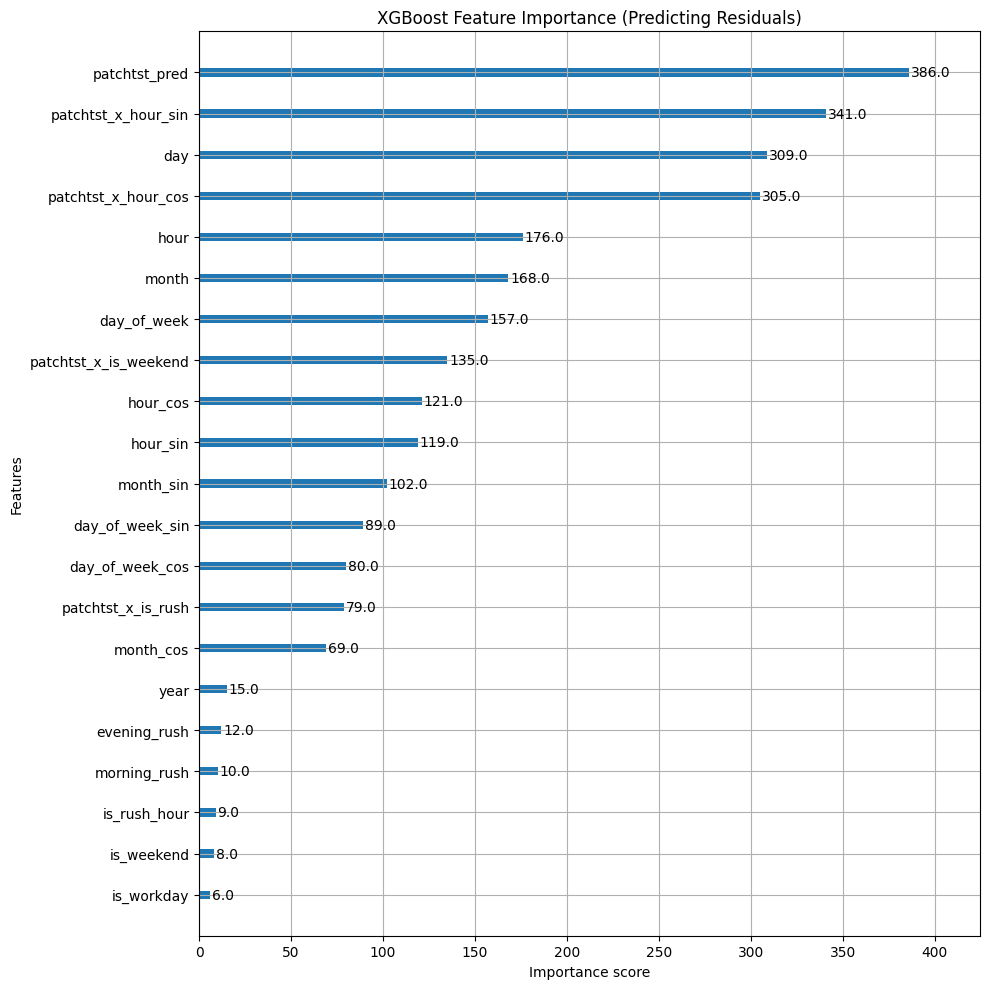

In [12]:
# === 8. Optimize and Train Refinement Model (XGBoost with Optuna using PatchTST Preds) ===
print("--- Optimizing Refinement Model (XGBoost with Optuna using PatchTST Preds) ---")
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import traceback
import torch
import matplotlib.pyplot as plt # Ensure plt is imported

# --- Clear PyTorch CUDA cache ---
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("Cleared PyTorch CUDA cache.")

# --- Check for necessary variables (using ALIGNED versions from previous cell) ---
required_vars = [
    'patchtst_train_pred_scaled', 'train_temporal', 'y_train_scaled_aligned',
    'patchtst_val_pred_scaled', 'val_temporal', 'y_val_scaled_aligned',
    'patchtst_test_pred_scaled', 'test_temporal', 'y_test_scaled_aligned',
    'temporal_features', 'scaler', 'y_test_orig_aligned' # Use the aligned original test targets
]
for var in required_vars:
    if var not in locals():
        raise NameError(f"Variable '{var}' not found. Ensure the previous cell (generating PatchTST preds and aligning data) ran successfully.")

# --- Calculate Residuals (TARGET for XGBoost) ---
# Use aligned targets and predictions
y_train_refine_resid = y_train_scaled_aligned - patchtst_train_pred_scaled
y_val_refine_resid = y_val_scaled_aligned - patchtst_val_pred_scaled
y_test_refine_resid = y_test_scaled_aligned - patchtst_test_pred_scaled # Used for dtest label
print("Calculated residuals for XGBoost target using PatchTST predictions.")

# --- Prepare Base Input Features for Refinement ---
# Combine PatchTST prediction and original temporal features into DataFrames
base_feature_names = ['patchtst_pred'] + temporal_features # Renamed feature
X_train_refine_df = pd.DataFrame(
    np.concatenate((patchtst_train_pred_scaled.reshape(-1, 1), train_temporal), axis=1),
    columns=base_feature_names
)
X_val_refine_df = pd.DataFrame(
    np.concatenate((patchtst_val_pred_scaled.reshape(-1, 1), val_temporal), axis=1),
    columns=base_feature_names
)
X_test_refine_df = pd.DataFrame(
    np.concatenate((patchtst_test_pred_scaled.reshape(-1, 1), test_temporal), axis=1),
    columns=base_feature_names
)

# --- Feature Engineering for XGBoost (Simplified: No Lagged Residuals) ---
print("Adding interaction features...")
interaction_features = []

for df in [X_train_refine_df, X_val_refine_df, X_test_refine_df]:
    # Interaction Features using PatchTST prediction
    df['patchtst_x_hour_sin'] = df['patchtst_pred'] * df['hour_sin']
    df['patchtst_x_hour_cos'] = df['patchtst_pred'] * df['hour_cos']
    df['patchtst_x_is_weekend'] = df['patchtst_pred'] * df['is_weekend']
    df['patchtst_x_is_rush'] = df['patchtst_pred'] * df['is_rush_hour']

# Define new feature sets
interaction_features = ['patchtst_x_hour_sin', 'patchtst_x_hour_cos', 'patchtst_x_is_weekend', 'patchtst_x_is_rush']
all_refinement_features = base_feature_names + interaction_features
print(f"Total refinement features: {len(all_refinement_features)}")

# --- Data is already aligned, no NaN dropping needed ---
y_train_refine_resid_final = y_train_refine_resid
y_val_refine_resid_final = y_val_refine_resid
y_test_refine_resid_final = y_test_refine_resid # For dtest label

patchtst_train_pred_scaled_final = patchtst_train_pred_scaled
patchtst_val_pred_scaled_final = patchtst_val_pred_scaled
patchtst_test_pred_scaled_final = patchtst_test_pred_scaled

y_test_orig_final = y_test_orig_aligned # Use the aligned original test targets

print(f"Shapes being used for XGBoost:")
print(f"Train X: {X_train_refine_df.shape}, Train y: {y_train_refine_resid_final.shape}")
print(f"Val X: {X_val_refine_df.shape}, Val y: {y_val_refine_resid_final.shape}")
print(f"Test X: {X_test_refine_df.shape}, Test y: {y_test_refine_resid_final.shape}")

# --- Create DMatrix ---
X_train_refine_final = X_train_refine_df[all_refinement_features].values
X_val_refine_final = X_val_refine_df[all_refinement_features].values
X_test_refine_final = X_test_refine_df[all_refinement_features].values

dtrain_refine = xgb.DMatrix(X_train_refine_final, label=y_train_refine_resid_final, feature_names=all_refinement_features)
dval_refine = xgb.DMatrix(X_val_refine_final, label=y_val_refine_resid_final, feature_names=all_refinement_features)
dtest_refine = xgb.DMatrix(X_test_refine_final, label=y_test_refine_resid_final, feature_names=all_refinement_features)
# --- End DMatrix ---

# --- Define the objective function for Optuna (Predicting Residuals) ---
def objective_xgb(trial):
    use_gpu = torch.cuda.is_available()
    device_choice = 'cuda' if use_gpu else 'cpu'
    # Force hist for GPU, allow auto for CPU
    tree_method_choice = 'hist' if use_gpu else trial.suggest_categorical('tree_method_cpu', ['exact', 'approx', 'hist'])
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-5, 20.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-5, 20.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'random_state': 42,
        'n_jobs': -1 # Use all available CPU cores
    }
    # Set device and tree_method based on availability
    if use_gpu:
        params['device'] = device_choice
        params['tree_method'] = tree_method_choice
    elif tree_method_choice != 'exact': # CPU only supports exact, approx, hist
         params['tree_method'] = tree_method_choice

    if params['booster'] == 'gbtree':
        params['max_depth'] = trial.suggest_int('max_depth', 3, 12)
        params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 25)
        params['eta'] = trial.suggest_float('eta', 5e-4, 0.4, log=True) # Learning rate
        params['gamma'] = trial.suggest_float('gamma', 1e-9, 10.0, log=True) # Min loss reduction for split
        if params.get('tree_method', 'auto') == 'hist': # grow_policy only for hist
             params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    elif params['booster'] == 'dart':
        params['max_depth'] = trial.suggest_int('max_depth_dart', 3, 12) # Use different name to avoid conflict
        params['eta'] = trial.suggest_float('eta_dart', 5e-4, 0.4, log=True)
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 0.6, log=True)
        params['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 0.6, log=True)

    # Use a wider range for num_boost_round, Optuna + early stopping will handle it
    num_boost_round = trial.suggest_int('num_boost_round', 100, 2000, step=100)
    early_stopping_rounds = 50

    print(f"\n--- Starting Trial {trial.number} with params: {params} ---")
    try:
        bst = xgb.train(
            params,
            dtrain_refine,
            num_boost_round=num_boost_round,
            evals=[(dval_refine, 'validation')],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=100 # Print progress every 100 rounds
        )
        best_rmse = bst.best_score
        trial.set_user_attr("best_iteration", bst.best_iteration)
        print(f"--- Trial {trial.number} finished successfully (best_score={best_rmse:.6f}) ---")
    except RuntimeError as rt_e:
        print(f"Trial {trial.number}: RuntimeError (potentially CUDA OOM) - {rt_e}")
        traceback.print_exc()
        if 'CUDA' in str(rt_e) and torch.cuda.is_available():
             print("Attempting to clear CUDA cache after error...")
             torch.cuda.empty_cache()
        return float('inf') # Fail the trial
    except xgb.core.XGBoostError as xgb_e:
        print(f"Trial {trial.number}: XGBoostError - {xgb_e}")
        traceback.print_exc()
        return float('inf')
    except Exception as e:
        print(f"Trial {trial.number}: General Error - {e}")
        traceback.print_exc()
        return float('inf')

    if np.isnan(best_rmse) or np.isinf(best_rmse):
        print(f"Trial {trial.number}: Invalid RMSE ({best_rmse}).")
        return float('inf')
    return best_rmse

# --- Optuna Study Creation and Callback ---
study_xgb = optuna.create_study(direction='minimize')
def optuna_callback(study, trial):
    if trial.state == optuna.trial.TrialState.COMPLETE:
        print(f"Callback: Trial {trial.number} finished with value (Residual RMSE): {trial.value:.6f}. Best is trial {study.best_trial.number} with value: {study.best_value:.6f}.")
    elif trial.state == optuna.trial.TrialState.FAIL:
        print(f"Callback: Trial {trial.number} failed.")

# --- Run Optimization ---
print("Starting Optuna optimization for XGBoost...")
try:
    # Adjust n_trials and timeout as needed
    study_xgb.optimize(objective_xgb, n_trials=50, timeout=1800, callbacks=[optuna_callback]) # e.g., 50 trials, 30 min timeout
except Exception as e:
    print(f"Optuna optimization process failed: {e}")
    traceback.print_exc()

# --- Process Optimization Results ---
if not study_xgb.trials or study_xgb.best_trial is None or study_xgb.best_value == float('inf'):
    print("Optuna optimization failed or yielded no valid trials. Cannot proceed with XGBoost refinement.")
    final_xgb_refine_model = None
    test_rmse_xgb, test_mae_xgb = float('inf'), float('inf')
    # Fallback uses ORIGINAL PatchTST predictions (aligned)
    final_test_pred_xgb = scaler.inverse_transform(patchtst_test_pred_scaled_final.reshape(-1, 1)).flatten()
    final_test_pred_xgb = np.clip(final_test_pred_xgb, 0, None) # Clip fallback too
else:
    # --- Get Best Parameters and Iteration ---
    best_params_xgb = study_xgb.best_params
    # Remove CPU-specific tree method if present
    best_params_xgb.pop('tree_method_cpu', None)
    best_iteration_optuna = study_xgb.best_trial.user_attrs.get("best_iteration")

    if best_iteration_optuna is None:
         print("Warning: Could not retrieve best_iteration from Optuna trial. Using num_boost_round from params or a default.")
         # Use the suggested num_boost_round if available, otherwise a default
         num_boost_round_final = best_params_xgb.pop('num_boost_round', 1000) # Default to 1000 if not found
    else:
        # Use the best iteration found during Optuna's early stopping
        num_boost_round_final = best_iteration_optuna
        best_params_xgb.pop('num_boost_round', None) # Remove num_boost_round if it was suggested

    print("\nBest hyperparameters found by Optuna (for residuals):")
    print(best_params_xgb)
    print(f"Best validation Residual RMSE (scaled): {study_xgb.best_value:.6f}")
    print(f"Best number of boosting rounds from Optuna trial: {num_boost_round_final}")

    # --- Train Final XGBoost Model on Residuals ---
    print("\nTraining final XGBoost refinement model on residuals...")
    final_params = best_params_xgb.copy()
    final_params['objective'] = 'reg:squarederror'
    final_params['eval_metric'] = 'rmse'
    final_params['random_state'] = 42
    final_params['n_jobs'] = -1
    # Set device/tree_method for final training
    if torch.cuda.is_available():
        final_params['device'] = 'cuda'
        final_params['tree_method'] = 'hist'
    else:
        # Use 'hist' for CPU as well, generally faster for larger datasets
        final_params['tree_method'] = 'hist'

    # Use early stopping in final training as well
    final_early_stopping_rounds = 50

    try:
        final_xgb_refine_model = xgb.train(
            final_params,
            dtrain_refine,
            # Train for the best iteration found + patience, let early stopping find the optimal point again
            num_boost_round=num_boost_round_final + final_early_stopping_rounds,
            evals=[(dtrain_refine, 'train_resid'), (dval_refine, 'val_resid')],
            early_stopping_rounds=final_early_stopping_rounds,
            verbose_eval=100 # Show progress
        )
        # Use the actual best iteration from the final training run
        actual_best_iteration = final_xgb_refine_model.best_iteration
        print(f"Final XGBoost refinement model (predicting residuals) fitted. Best iteration: {actual_best_iteration}")

        # --- Predict Residuals with the final model ---
        xgb_train_pred_scaled_resid = final_xgb_refine_model.predict(dtrain_refine, iteration_range=(0, actual_best_iteration + 1))
        xgb_val_pred_scaled_resid = final_xgb_refine_model.predict(dval_refine, iteration_range=(0, actual_best_iteration + 1))
        xgb_test_pred_scaled_resid = final_xgb_refine_model.predict(dtest_refine, iteration_range=(0, actual_best_iteration + 1))

        # --- Combine ORIGINAL PatchTST prediction and XGBoost residual prediction ---
        final_train_pred_scaled = patchtst_train_pred_scaled_final + xgb_train_pred_scaled_resid
        final_val_pred_scaled = patchtst_val_pred_scaled_final + xgb_val_pred_scaled_resid
        final_test_pred_scaled = patchtst_test_pred_scaled_final + xgb_test_pred_scaled_resid

        # --- Inverse transform the COMBINED predictions ---
        final_train_pred_xgb = scaler.inverse_transform(final_train_pred_scaled.reshape(-1, 1)).flatten()
        final_val_pred_xgb = scaler.inverse_transform(final_val_pred_scaled.reshape(-1, 1)).flatten()
        final_test_pred_xgb = scaler.inverse_transform(final_test_pred_scaled.reshape(-1, 1)).flatten()

        # Clip predictions
        final_train_pred_xgb = np.clip(final_train_pred_xgb, 0, None)
        final_val_pred_xgb = np.clip(final_val_pred_xgb, 0, None)
        final_test_pred_xgb = np.clip(final_test_pred_xgb, 0, None)

        # --- Evaluate Final COMBINED XGBoost Refinement ---
        print("\n--- Optimized XGBoost Refinement Evaluation (Test Set - Combined Preds) ---")
        # Use ALIGNED ORIGINAL test targets for evaluation
        test_rmse_xgb = np.sqrt(mean_squared_error(y_test_orig_final, final_test_pred_xgb))
        test_mae_xgb = mean_absolute_error(y_test_orig_final, final_test_pred_xgb)
        print(f"Optimized (PatchTST + XGBoost) - Test RMSE: {test_rmse_xgb:.2f}, Test MAE: {test_mae_xgb:.2f}")

        # --- Feature Importance ---
        try:
            fig, ax = plt.subplots(figsize=(10, max(8, len(all_refinement_features) // 2)))
            xgb.plot_importance(final_xgb_refine_model, ax=ax, max_num_features=40)
            plt.title("XGBoost Feature Importance (Predicting Residuals)")
            plt.tight_layout()
            plt.show()
        except Exception as plot_e:
            print(f"Could not plot feature importance: {plot_e}")

    except xgb.core.XGBoostError as xgb_e:
        print(f"XGBoostError during final fitting/prediction: {xgb_e}")
        traceback.print_exc()
        test_rmse_xgb, test_mae_xgb = float('inf'), float('inf')
        # Fallback uses ORIGINAL PatchTST predictions (aligned)
        final_test_pred_xgb = scaler.inverse_transform(patchtst_test_pred_scaled_final.reshape(-1, 1)).flatten()
        final_test_pred_xgb = np.clip(final_test_pred_xgb, 0, None)
    except Exception as e:
        print(f"General error during final XGBoost fitting/prediction: {e}")
        traceback.print_exc()
        test_rmse_xgb, test_mae_xgb = float('inf'), float('inf')
        # Fallback uses ORIGINAL PatchTST predictions (aligned)
        final_test_pred_xgb = scaler.inverse_transform(patchtst_test_pred_scaled_final.reshape(-1, 1)).flatten()
        final_test_pred_xgb = np.clip(final_test_pred_xgb, 0, None)


--- Training Refinement Model (Simple NN using PatchTST Preds) ---

NN Refinement Model Architecture:
RefinementNN(
  (layers): ModuleList(
    (0): Linear(in_features=21, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)
Starting NN refinement training...
Epoch 1/100, NN Train Loss (Resid): 0.143092, NN Val Loss (Resid): 0.099577
  -> New best NN val loss: 0.099577. Saving model.
Epoch 2/100, NN Train Loss (Resid): 0.067831, NN Val Loss (Resid): 0.094088
  -> New best NN val 

C:\Users\PLN\AppData\Local\Temp\ipykernel_15912\205148819.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_refine_model.load_state_dict(torch.load(nn_model_save_path

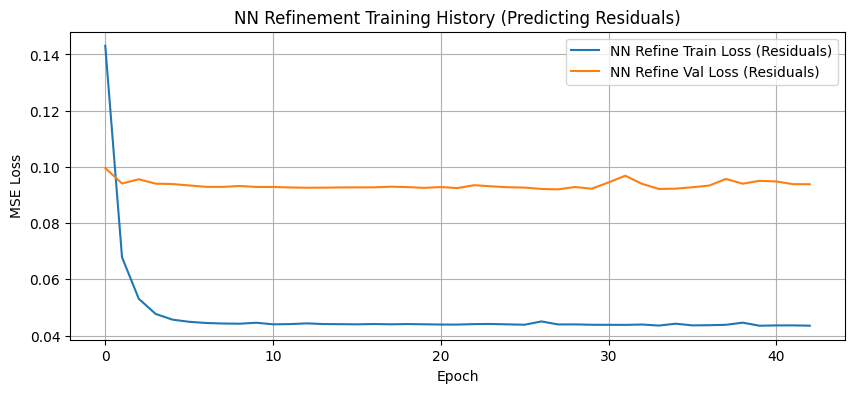


--- Optimized NN Refinement Evaluation (Test Set - Combined Preds) ---
Optimized (PatchTST + NN) - Test RMSE: 5.14, Test MAE: 3.79

--- Final Comparison on Test Set (PatchTST Base) ---
PatchTST Only - Test RMSE: 5.21, Test MAE: 3.88


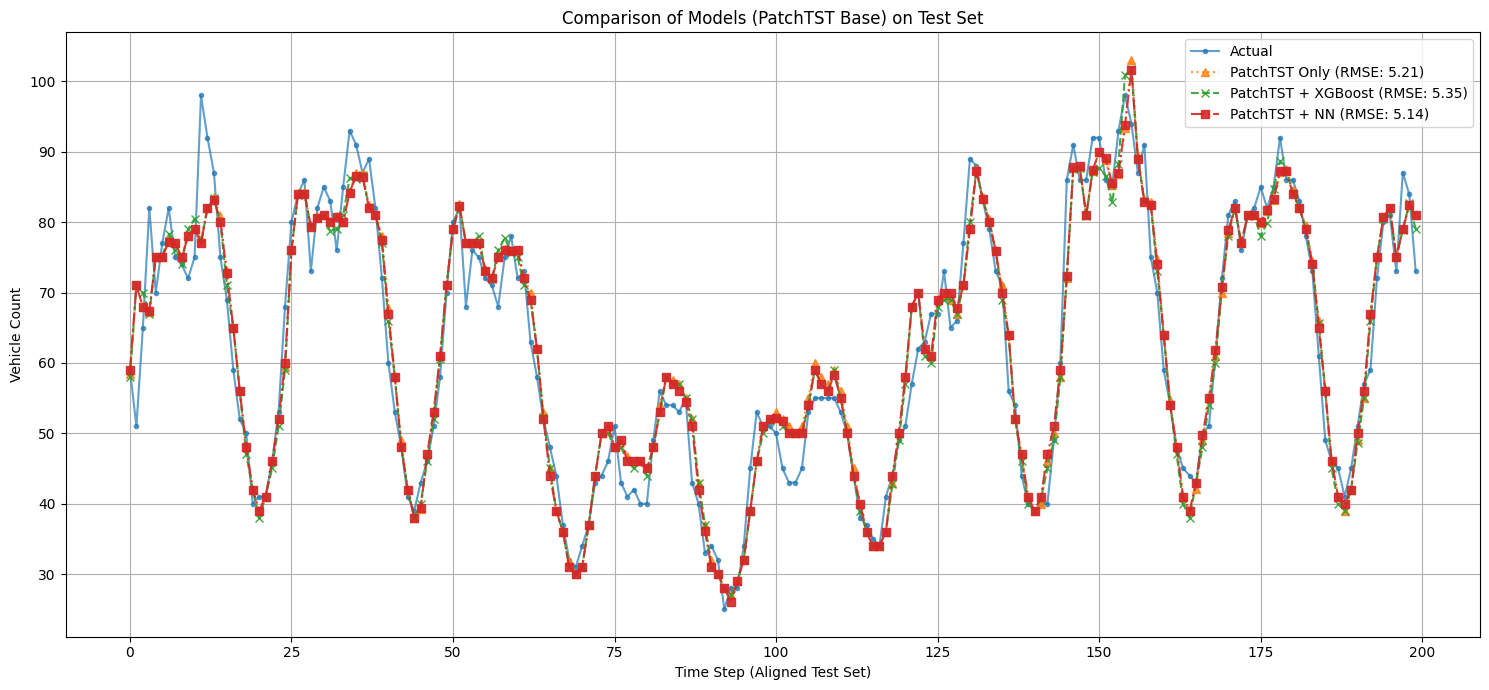


===== FINAL RESULTS SUMMARY (Test Set - PatchTST Base) =====
                Model      RMSE       MAE
2       PatchTST + NN  5.135649  3.791607
0       PatchTST Only  5.208649  3.875218
1  PatchTST + XGBoost  5.349018  3.926213


In [13]:
# === 9. Train and Evaluate Refinement Model (Simple NN using PatchTST Preds) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import os

print("\n--- Training Refinement Model (Simple NN using PatchTST Preds) ---")

# --- Check for necessary variables (using ALIGNED versions from previous cells) ---
required_vars_nn = [
    'X_train_refine_df', 'X_val_refine_df', 'X_test_refine_df',
    'y_train_refine_resid_final', 'y_val_refine_resid_final', 'y_test_refine_resid_final',
    'patchtst_train_pred_scaled_final', 'patchtst_val_pred_scaled_final', 'patchtst_test_pred_scaled_final',
    'all_refinement_features', 'scaler', 'y_test_orig_final', 'device'
]
for var in required_vars_nn:
    if var not in locals():
        raise NameError(f"Variable '{var}' for NN refinement not found. Ensure previous cells (PatchTST eval, XGBoost refinement) ran successfully.")

class RefinementNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], output_dim=1, dropout_rate=0.4):
        super(RefinementNN, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        current_dim = input_dim
        for h_dim in hidden_dims:
            self.layers.append(nn.Linear(current_dim, h_dim))
            self.batch_norms.append(nn.BatchNorm1d(h_dim))
            current_dim = h_dim
        self.output_layer = nn.Linear(current_dim, output_dim)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if x.size(0) > 1:
                x = self.batch_norms[i](x)
            x = F.leaky_relu(x, negative_slope=0.01)
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

# Prepare data for NN refinement (Using features derived from PatchTST)
X_train_refine_tensor = torch.tensor(X_train_refine_df[all_refinement_features].values, dtype=torch.float32).to(device)
X_val_refine_tensor = torch.tensor(X_val_refine_df[all_refinement_features].values, dtype=torch.float32).to(device)
X_test_refine_tensor = torch.tensor(X_test_refine_df[all_refinement_features].values, dtype=torch.float32).to(device)

y_train_refine_tensor = torch.tensor(y_train_refine_resid_final, dtype=torch.float32).unsqueeze(1).to(device)
y_val_refine_tensor = torch.tensor(y_val_refine_resid_final, dtype=torch.float32).unsqueeze(1).to(device)
y_test_refine_tensor = torch.tensor(y_test_refine_resid_final, dtype=torch.float32).unsqueeze(1).to(device)

# --- Instantiate NN Model ---
nn_refine_model = RefinementNN(
    input_dim=X_train_refine_tensor.shape[1]
).to(device)

print("\nNN Refinement Model Architecture:")
print(nn_refine_model)

# --- Setup Training ---
nn_criterion = nn.MSELoss()
nn_optimizer = torch.optim.AdamW(nn_refine_model.parameters(), lr=0.001, weight_decay=1e-4)

nn_train_dataset = TensorDataset(X_train_refine_tensor, y_train_refine_tensor)
nn_train_loader = DataLoader(nn_train_dataset, batch_size=128, shuffle=True)

nn_epochs = 100
nn_patience = 15
nn_patience_counter = 0
best_nn_val_loss = float('inf')
nn_train_losses = []
nn_val_losses = []
nn_model_save_path = "best_nn_refine_patchtst_model.pt"

print("Starting NN refinement training...")
for epoch in range(nn_epochs):
    nn_refine_model.train()
    epoch_loss = 0
    for batch_X, batch_y_resid in nn_train_loader:
        nn_optimizer.zero_grad()
        outputs = nn_refine_model(batch_X)
        loss = nn_criterion(outputs, batch_y_resid)
        loss.backward()
        nn_optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(nn_train_loader)
    nn_train_losses.append(avg_train_loss)

    # Validation
    nn_refine_model.eval()
    with torch.no_grad():
        val_outputs = nn_refine_model(X_val_refine_tensor)
        val_loss = nn_criterion(val_outputs, y_val_refine_tensor).item()
        nn_val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{nn_epochs}, NN Train Loss (Resid): {avg_train_loss:.6f}, NN Val Loss (Resid): {val_loss:.6f}")

    if val_loss < best_nn_val_loss:
        best_nn_val_loss = val_loss
        torch.save(nn_refine_model.state_dict(), nn_model_save_path)
        print(f"  -> New best NN val loss: {best_nn_val_loss:.6f}. Saving model.")
        nn_patience_counter = 0
    else:
        nn_patience_counter += 1
        if nn_patience_counter >= nn_patience:
            print(f"Early stopping NN refinement training at epoch {epoch+1}")
            break

# --- Load Best NN Model ---
if os.path.exists(nn_model_save_path):
    nn_refine_model.load_state_dict(torch.load(nn_model_save_path))
    print(f"\nBest NN refinement model loaded from '{nn_model_save_path}'.")
else:
    print(f"\nWarning: '{nn_model_save_path}' not found. Using model from the last epoch.")

# --- Plot NN Losses ---
plt.figure(figsize=(10, 4))
plt.plot(nn_train_losses, label='NN Refine Train Loss (Residuals)')
plt.plot(nn_val_losses, label='NN Refine Val Loss (Residuals)')
plt.title('NN Refinement Training History (Predicting Residuals)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Predict Residuals with NN ---
nn_refine_model.eval()
with torch.no_grad():
    nn_train_pred_scaled_resid = nn_refine_model(X_train_refine_tensor).squeeze().cpu().numpy()
    nn_val_pred_scaled_resid = nn_refine_model(X_val_refine_tensor).squeeze().cpu().numpy()
    nn_test_pred_scaled_resid = nn_refine_model(X_test_refine_tensor).squeeze().cpu().numpy()

# --- Combine PatchTST prediction and NN residual prediction ---
final_train_pred_scaled_nn = patchtst_train_pred_scaled_final + nn_train_pred_scaled_resid
final_val_pred_scaled_nn = patchtst_val_pred_scaled_final + nn_val_pred_scaled_resid
final_test_pred_scaled_nn = patchtst_test_pred_scaled_final + nn_test_pred_scaled_resid

# --- Inverse transform the COMBINED predictions ---
final_train_pred_nn = scaler.inverse_transform(final_train_pred_scaled_nn.reshape(-1, 1)).flatten()
final_val_pred_nn = scaler.inverse_transform(final_val_pred_scaled_nn.reshape(-1, 1)).flatten()
final_test_pred_nn = scaler.inverse_transform(final_test_pred_scaled_nn.reshape(-1, 1)).flatten()

final_train_pred_nn = np.clip(final_train_pred_nn, 0, None)
final_val_pred_nn = np.clip(final_val_pred_nn, 0, None)
final_test_pred_nn = np.clip(final_test_pred_nn, 0, None)

print("\n--- Optimized NN Refinement Evaluation (Test Set - Combined Preds) ---")
test_rmse_nn = np.sqrt(mean_squared_error(y_test_orig_final, final_test_pred_nn))
test_mae_nn = mean_absolute_error(y_test_orig_final, final_test_pred_nn)
print(f"Optimized (PatchTST + NN) - Test RMSE: {test_rmse_nn:.2f}, Test MAE: {test_mae_nn:.2f}")

print("\n--- Final Comparison on Test Set (PatchTST Base) ---")
print(f"PatchTST Only - Test RMSE: {patchtst_rmse:.2f}, Test MAE: {patchtst_mae:.2f}")

plt.figure(figsize=(15, 7))
plot_range = range(min(200, len(y_test_orig_final)))
plt.plot(plot_range, y_test_orig_final[plot_range], label='Actual', marker='.', linestyle='-', alpha=0.7)
plt.plot(plot_range, patchtst_test_pred_orig[plot_range], label=f'PatchTST Only (RMSE: {patchtst_rmse:.2f})', marker='^', linestyle=':', alpha=0.8)

if 'final_test_pred_xgb' in locals() and len(final_test_pred_xgb) == len(y_test_orig_final):
    plt.plot(plot_range, final_test_pred_xgb[plot_range], label=f'PatchTST + XGBoost (RMSE: {test_rmse_xgb:.2f})', marker='x', linestyle='--', alpha=0.9)
else:
    print(f"Warning: XGBoost prediction length might mismatch target length. Skipping plot.")

if len(final_test_pred_nn) == len(y_test_orig_final):
    plt.plot(plot_range, final_test_pred_nn[plot_range], label=f'PatchTST + NN (RMSE: {test_rmse_nn:.2f})', marker='s', linestyle='-.', alpha=0.9)
else:
    print(f"Warning: NN prediction length ({len(final_test_pred_nn)}) doesn't match target length ({len(y_test_orig_final)}). Skipping plot.")

plt.title('Comparison of Models (PatchTST Base) on Test Set')
plt.xlabel('Time Step (Aligned Test Set)')
plt.ylabel('Vehicle Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n===== FINAL RESULTS SUMMARY (Test Set - PatchTST Base) =====")
results_data = {
    'Model': ['PatchTST Only', 'PatchTST + XGBoost', 'PatchTST + NN'],
    'RMSE': [patchtst_rmse, test_rmse_xgb, test_rmse_nn],
    'MAE': [patchtst_mae, test_mae_xgb, test_mae_nn]
}
if 'test_rmse_xgb' not in locals() or test_rmse_xgb == float('inf'):
    results_data['RMSE'][1] = float('inf')
    results_data['MAE'][1] = float('inf')

results_df = pd.DataFrame(results_data)
print(results_df.sort_values('RMSE'))

In [14]:
# filepath: e:\a\Transformers_test_order.ipynb
# === Check Variables Before Final Comparison ===
print("--- Checking variable existence ---")
vars_to_check = [
    'y_test_orig_final',
    'patchtst_test_pred_orig',
    'final_test_pred_xgb',
    'final_test_pred_nn'
]
for var_name in vars_to_check:
    if var_name in locals():
        print(f"Variable '{var_name}' exists. Type: {type(locals()[var_name])}, Shape/Length: {getattr(locals()[var_name], 'shape', len(locals()[var_name]))}")
    else:
        print(f"Variable '{var_name}' is MISSING.")

# Optional: Print all local variables if needed
# print("\nAll local variables:", list(locals().keys()))

--- Checking variable existence ---
Variable 'y_test_orig_final' exists. Type: <class 'numpy.ndarray'>, Shape/Length: (2751,)
Variable 'patchtst_test_pred_orig' exists. Type: <class 'numpy.ndarray'>, Shape/Length: (2751,)
Variable 'final_test_pred_xgb' exists. Type: <class 'numpy.ndarray'>, Shape/Length: (2751,)
Variable 'final_test_pred_nn' exists. Type: <class 'numpy.ndarray'>, Shape/Length: (2751,)



===== LAST 24 HOURS RESULTS SUMMARY (Test Set - PatchTSMixer Base) =====
--- Checking variables within comparison cell scope ---
Variable 'y_test_orig_final' exists in this cell's scope.
Variable 'patchtst_test_pred_orig' exists in this cell's scope.
Variable 'final_test_pred_xgb' exists in this cell's scope.
Variable 'final_test_pred_nn' exists in this cell's scope.
--- All required variables confirmed within cell scope. Proceeding... ---
                    Model      RMSE       MAE
2       PatchTSMixer + NN  7.399335  5.824655
0       PatchTSMixer Only  7.524811  5.995179
1  PatchTSMixer + XGBoost  7.601070  5.909950


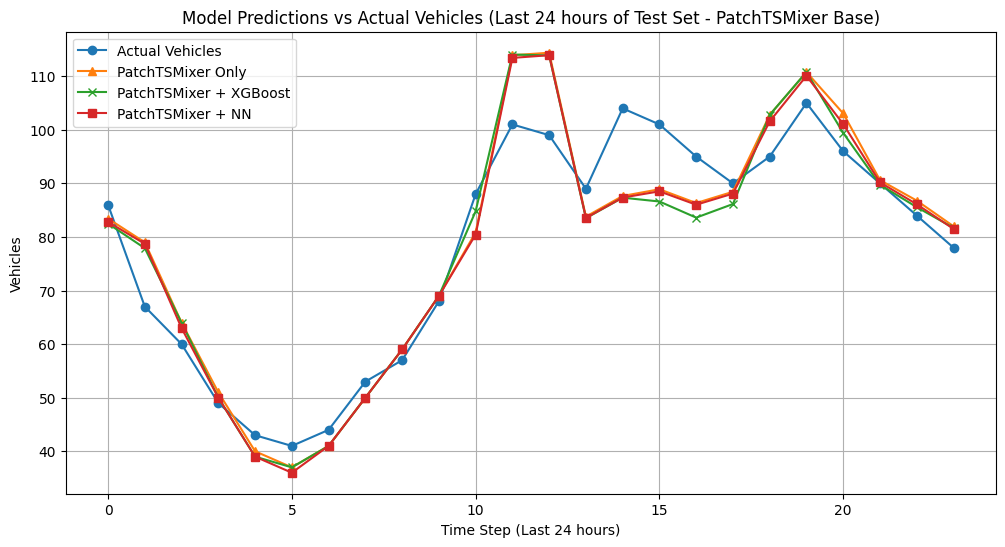

In [15]:
# === 11. Last 24 Hours Comparison (PatchTSMixer Base) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("\n===== LAST 24 HOURS RESULTS SUMMARY (Test Set - PatchTSMixer Base) =====")

# --- Explicitly check variables INSIDE this cell's scope ---
variables_exist_in_cell = True
required_vars_last24 = [
    'y_test_orig_final',
    'patchtst_test_pred_orig',
    'final_test_pred_xgb',
    'final_test_pred_nn'
]
missing_vars_in_cell = []

print("--- Checking variables within comparison cell scope ---")
for var_name in required_vars_last24:
    if var_name not in locals():
        variables_exist_in_cell = False
        missing_vars_in_cell.append(var_name)
        print(f"!!! Variable '{var_name}' is MISSING in this cell's scope !!!")
    else:
        print(f"Variable '{var_name}' exists in this cell's scope.")

# --- Proceed only if all variables are confirmed within this cell ---
if not variables_exist_in_cell:
    print(f"Error: Missing variables required for last 24-hour comparison: {', '.join(missing_vars_in_cell)}")
    print("This indicates an issue with variable scope or kernel state. Please re-run preceding cells or restart the kernel.")
else:
    print("--- All required variables confirmed within cell scope. Proceeding... ---")
    last_24_hours = 24

    # --- Check lengths (using the confirmed variables) ---
    min_len_last24 = len(y_test_orig_final)
    can_compare_patchtsmixer = True
    can_compare_xgb = True
    can_compare_nn = True # Changed from final_test_pred_nn to can_compare_nn

    if len(patchtst_test_pred_orig) != min_len_last24:
        print(f"Warning: Length mismatch for PatchTSMixer predictions ({len(patchtst_test_pred_orig)} vs {min_len_last24}). Cannot calculate last 24h metrics.")
        can_compare_patchtsmixer = False

    # Check existence again before accessing length for XGB
    if 'final_test_pred_xgb' not in locals() or len(final_test_pred_xgb) != min_len_last24:
         print(f"Warning: Length mismatch or missing 'final_test_pred_xgb'. Cannot calculate last 24h metrics for XGBoost.")
         can_compare_xgb = False

    # Check existence again before accessing length for NN
    if 'final_test_pred_nn' not in locals() or len(final_test_pred_nn) != min_len_last24:
         print(f"Warning: Length mismatch or missing 'final_test_pred_nn'. Cannot calculate last 24h metrics for NN.")
         can_compare_nn = False


    # --- Calculate Metrics for Last 24 Hours ---
    models_last24 = []
    rmse_last24 = []
    mae_last24 = []

    if can_compare_patchtsmixer:
        models_last24.append('PatchTSMixer Only')
        rmse_last24.append(np.sqrt(mean_squared_error(y_test_orig_final[-last_24_hours:], patchtst_test_pred_orig[-last_24_hours:])))
        mae_last24.append(mean_absolute_error(y_test_orig_final[-last_24_hours:], patchtst_test_pred_orig[-last_24_hours:]))

    if can_compare_xgb:
        models_last24.append('PatchTSMixer + XGBoost')
        rmse_last24.append(np.sqrt(mean_squared_error(y_test_orig_final[-last_24_hours:], final_test_pred_xgb[-last_24_hours:])))
        mae_last24.append(mean_absolute_error(y_test_orig_final[-last_24_hours:], final_test_pred_xgb[-last_24_hours:]))
    else:
         # Add placeholders if XGBoost failed or length mismatched
         if 'PatchTSMixer + XGBoost' not in models_last24:
             models_last24.append('PatchTSMixer + XGBoost')
             rmse_last24.append(float('inf'))
             mae_last24.append(float('inf'))


    if can_compare_nn:
        # --- Use correct variable name 'final_test_pred_nn' ---
        models_last24.append('PatchTSMixer + NN')
        rmse_last24.append(np.sqrt(mean_squared_error(y_test_orig_final[-last_24_hours:], final_test_pred_nn[-last_24_hours:])))
        mae_last24.append(mean_absolute_error(y_test_orig_final[-last_24_hours:], final_test_pred_nn[-last_24_hours:]))
    else:
        # Add placeholders if NN failed or length mismatched
        # --- Use correct model name 'PatchTSMixer + NN' ---
        if 'PatchTSMixer + NN' not in models_last24:
            models_last24.append('PatchTSMixer + NN')
            rmse_last24.append(float('inf'))
            mae_last24.append(float('inf'))

    last_24_hours_results_data = {
        'Model': models_last24,
        'RMSE': rmse_last24,
        'MAE': mae_last24
    }

    if last_24_hours_results_data['Model']: # Check if any models could be compared
        last_24_hours_results_df = pd.DataFrame(last_24_hours_results_data)
        print(last_24_hours_results_df.sort_values('RMSE'))

        # --- Plot Last 24 Hours ---
        plt.figure(figsize=(12, 6))
        plt.plot(range(last_24_hours), y_test_orig_final[-last_24_hours:], label='Actual Vehicles', marker='o')

        if can_compare_patchtsmixer:
            plt.plot(range(last_24_hours), patchtst_test_pred_orig[-last_24_hours:], label='PatchTSMixer Only', marker='^')
        if can_compare_xgb:
            plt.plot(range(last_24_hours), final_test_pred_xgb[-last_24_hours:], label='PatchTSMixer + XGBoost', marker='x')
        if can_compare_nn:
            # --- Use correct variable name 'final_test_pred_nn' ---
            plt.plot(range(last_24_hours), final_test_pred_nn[-last_24_hours:], label='PatchTSMixer + NN', marker='s')

        plt.title('Model Predictions vs Actual Vehicles (Last 24 hours of Test Set - PatchTSMixer Base)')
        plt.xlabel('Time Step (Last 24 hours)')
        plt.ylabel('Vehicles')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Could not generate last 24-hour comparison due to missing data or length mismatches.")



--- Training NN to Mimic PatchTSMixer+XGBoost (Knowledge Distillation - Further Enhanced) ---
Error: Missing variables required for distillation: X_train_refine_tensor, X_val_refine_tensor, X_test_refine_tensor, final_train_pred_scaled, final_val_pred_scaled, y_test_orig_final, scaler, device, RefinementNN
Ensure previous cells (Corrected PatchTSMixer '1ec2bdb3', Corrected XGBoost 'de4b0267', Corrected NN '28cacdfd') ran successfully in order.
Distillation Target Shape (Train): torch.Size([10046, 1])
Distillation Target Shape (Val): torch.Size([1291, 1])
Distillation Input Shape (Train): torch.Size([10046, 21])

Distilled NN Model Architecture (Further Enhanced):
RefinementNN(
  (layers): ModuleList(
    (0): Linear(in_features=21, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_feature

c:\Users\PLN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/500, Distill Train Loss: 0.130703, Distill Val Loss: 2.826166, LR: 0.000500
  -> New best distillation val loss: 2.826166. Saving model.
Epoch 2/500, Distill Train Loss: 0.053479, Distill Val Loss: 0.128992, LR: 0.000500
  -> New best distillation val loss: 0.128992. Saving model.
Epoch 3/500, Distill Train Loss: 0.044847, Distill Val Loss: 2.180529, LR: 0.000500
Epoch 4/500, Distill Train Loss: 0.037957, Distill Val Loss: 0.073323, LR: 0.000500
  -> New best distillation val loss: 0.073323. Saving model.
Epoch 5/500, Distill Train Loss: 0.035401, Distill Val Loss: 0.174211, LR: 0.000500
Epoch 6/500, Distill Train Loss: 0.032440, Distill Val Loss: 1.377364, LR: 0.000500
Epoch 7/500, Distill Train Loss: 0.030767, Distill Val Loss: 0.042332, LR: 0.000500
  -> New best distillation val loss: 0.042332. Saving model.
Epoch 8/500, Distill Train Loss: 0.027693, Distill Val Loss: 0.329873, LR: 0.000500
Epoch 9/500, Distill Train Loss: 0.029129, Distill Val Loss: 0.174534, LR: 0.000500


C:\Users\PLN\AppData\Local\Temp\ipykernel_15912\2727264155.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distilled_nn_model.load_state_dict(torch.load(distill_model_

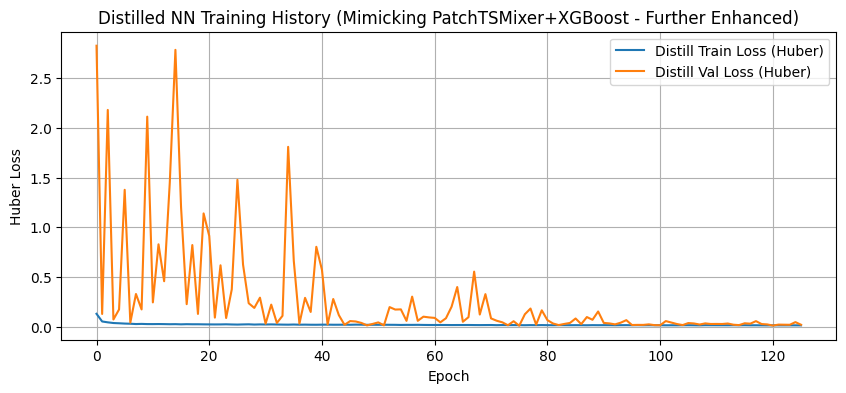


Distillation training complete. Proceed to the next cell for evaluation.
Cleared some distillation tensors from CUDA memory.


In [16]:
# === 11. Train Model to Mimic PatchTSMixer+XGBoost (Knowledge Distillation using NN) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time # Added for timing

print("\n--- Training NN to Mimic PatchTSMixer+XGBoost (Knowledge Distillation - Further Enhanced) ---") # Enhanced title

# --- Check if necessary variables exist ---
# Need:
# 1. Inputs used for XGBoost refinement (X_*_refine_tensor from NN cell)
# 2. Targets: The final combined predictions from PatchTSMixer+XGBoost (final_*_pred_scaled from XGBoost cell)
# 3. Original test targets for final evaluation (y_test_orig_final from PatchTSMixer cell)
# 4. Scaler for inverse transform (from PatchTSMixer cell)
# 5. Device for PyTorch (from PatchTSMixer cell)
# 6. RefinementNN class definition (from NN cell)

required_vars_distill = [
    'X_train_refine_tensor', 'X_val_refine_tensor', 'X_test_refine_tensor', # Inputs (PatchTSMixer pred + temporal) from NN cell
    'final_train_pred_scaled', 'final_val_pred_scaled', # Targets (Combined PatchTSMixer+XGBoost scaled preds) from XGBoost cell
    'y_test_orig_final', # Original test targets (aligned) from PatchTSMixer cell
    'scaler', # From PatchTSMixer cell
    'device', # From PatchTSMixer cell
    'RefinementNN' # The NN class defined in NN cell
]
missing_vars = [var for var in required_vars_distill if var not in locals()]

if missing_vars:
    print(f"Error: Missing variables required for distillation: {', '.join(missing_vars)}")
    print("Ensure previous cells (Corrected PatchTSMixer '1ec2bdb3', Corrected XGBoost 'de4b0267', Corrected NN '28cacdfd') ran successfully in order.")
# Check if XGBoost refinement actually produced a model (Optuna might have failed)
elif 'final_xgb_refine_model' not in locals() or final_xgb_refine_model is None: # Check if model is None too
     print("Warning: XGBoost refinement model variable ('final_xgb_refine_model') not found or is None. Optuna might have failed.")
     print("Distillation will proceed using PatchTSMixer-only predictions as the target.")
     # Use PatchTSMixer predictions as fallback targets
     # Ensure the fallback variables exist
     if 'patchtsmixer_train_pred_scaled_final' in locals() and 'patchtsmixer_val_pred_scaled_final' in locals():
         final_train_pred_scaled = patchtsmixer_train_pred_scaled_final.copy()
         final_val_pred_scaled = patchtsmixer_val_pred_scaled_final.copy()
     else:
         raise NameError("Fallback PatchTSMixer predictions ('patchtsmixer_train_pred_scaled_final', 'patchtsmixer_val_pred_scaled_final') not found. Cannot proceed.")

# Proceed if required variables exist (even if XGBoost model itself is None)
# --- Prepare Targets (Use Scaled PatchTSMixer+XGBoost Predictions, or fallback) ---
y_train_distill_target_scaled_np = np.array(final_train_pred_scaled) # From XGBoost cell (or fallback)
y_val_distill_target_scaled_np = np.array(final_val_pred_scaled)     # From XGBoost cell (or fallback)

# Convert targets to Tensors, unsqueeze for loss calculation
y_train_distill_target_tensor = torch.tensor(y_train_distill_target_scaled_np, dtype=torch.float32).unsqueeze(1).to(device)
y_val_distill_target_tensor = torch.tensor(y_val_distill_target_scaled_np, dtype=torch.float32).unsqueeze(1).to(device)

print(f"Distillation Target Shape (Train): {y_train_distill_target_tensor.shape}")
print(f"Distillation Target Shape (Val): {y_val_distill_target_tensor.shape}")
print(f"Distillation Input Shape (Train): {X_train_refine_tensor.shape}") # Input is the same as refinement models

# --- Instantiate a NEW NN Model for Distillation (Further Enhanced Architecture) ---
# Increase complexity further: add another layer, adjust dimensions
distilled_nn_model = RefinementNN(
    input_dim=X_train_refine_tensor.shape[1], # Input dim is number of refinement features
    hidden_dims=[512, 256, 128, 64, 32], # Added 512 layer
    output_dim=1,
    dropout_rate=0.2 # Further reduced dropout
).to(device)

print("\nDistilled NN Model Architecture (Further Enhanced):") # Enhanced title
print(distilled_nn_model)

# --- Define Optimizer and Criterion (Further Enhanced Training Params) ---
# Consider HuberLoss for potentially less sensitivity to outliers in teacher predictions
distill_criterion = nn.HuberLoss(delta=1.0) # Changed from MSELoss to HuberLoss
# Keep LR, increase weight decay slightly
distill_optimizer = torch.optim.AdamW(distilled_nn_model.parameters(), lr=5e-4, weight_decay=1e-4) # Increased weight decay
# Increase scheduler patience further
distill_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(distill_optimizer, 'min', factor=0.5, patience=20, verbose=True) # Increased scheduler patience

# --- Create DataLoaders (Use Refinement inputs, NEW targets) ---
# Inputs are the same tensors used for the refinement models (X_*_refine_tensor)
distill_train_dataset = TensorDataset(X_train_refine_tensor, y_train_distill_target_tensor)
# Slightly smaller batch size might help with generalization on complex targets
distill_train_loader = DataLoader(distill_train_dataset, batch_size=64, shuffle=True) # Reduced batch_size

# Validation uses X_val_refine_tensor and the combined XGBoost predictions as target
distill_val_dataset = TensorDataset(X_val_refine_tensor, y_val_distill_target_tensor)
distill_val_loader = DataLoader(distill_val_dataset, batch_size=256, shuffle=False) # Larger batch size for validation is often fine

# --- Training Loop (Further Enhanced Training Params) ---
distill_epochs = 500 # Significantly increased epochs
distill_patience = 50 # Increased patience for early stopping
distill_patience_counter = 0
best_distill_val_loss = float('inf')
distill_train_losses = []
distill_val_losses = []
distill_model_save_path = "best_distilled_nn_PatchTST_model_further_enhanced.pt" # Updated save path

print("\nStarting Distillation Training (NN mimicking PatchTSMixer+XGBoost - Further Enhanced)...") # Enhanced title
training_start_time = time.time()
for epoch in range(distill_epochs):
    distilled_nn_model.train()
    epoch_train_loss = 0.0 # Use float for accumulation
    batch_count = 0
    for batch_X, batch_y_target_tensor in distill_train_loader: # batch_X is refinement features
        distill_optimizer.zero_grad()
        outputs = distilled_nn_model(batch_X) # Predict the combined value
        loss = distill_criterion(outputs, batch_y_target_tensor)
        loss.backward()
        # Apply Gradient Clipping
        torch.nn.utils.clip_grad_norm_(distilled_nn_model.parameters(), max_norm=1.0) # Keep applied
        distill_optimizer.step()
        epoch_train_loss += loss.item()
        batch_count += 1

    avg_train_loss = epoch_train_loss / batch_count if batch_count > 0 else 0.0
    distill_train_losses.append(avg_train_loss)

    # Validation
    distilled_nn_model.eval()
    epoch_val_loss = 0.0
    val_batch_count = 0
    with torch.no_grad():
        for batch_X_val, batch_y_val_target_tensor in distill_val_loader:
            val_outputs = distilled_nn_model(batch_X_val) # Predict combined value
            # Use the same criterion for validation loss calculation
            loss = distill_criterion(val_outputs, batch_y_val_target_tensor)
            epoch_val_loss += loss.item()
            val_batch_count += 1

    avg_val_loss = epoch_val_loss / val_batch_count if val_batch_count > 0 else 0.0
    distill_val_losses.append(avg_val_loss)

    # Step the scheduler based on validation loss
    distill_scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{distill_epochs}, Distill Train Loss: {avg_train_loss:.6f}, Distill Val Loss: {avg_val_loss:.6f}, LR: {distill_optimizer.param_groups[0]['lr']:.6f}") # Added LR print

    # Early stopping
    if avg_val_loss < best_distill_val_loss:
        best_distill_val_loss = avg_val_loss
        torch.save(distilled_nn_model.state_dict(), distill_model_save_path)
        distill_patience_counter = 0
        print(f"  -> New best distillation val loss: {best_distill_val_loss:.6f}. Saving model.")
    else:
        distill_patience_counter += 1
        if distill_patience_counter >= distill_patience:
            print(f"Early stopping distillation training at epoch {epoch+1}")
            break

training_end_time = time.time()
print(f"Distillation training loop finished in {training_end_time - training_start_time:.2f} seconds.")

# --- Load Best Distilled Model ---
if os.path.exists(distill_model_save_path):
    distilled_nn_model.load_state_dict(torch.load(distill_model_save_path))
    print(f"\nBest distilled NN model loaded from '{distill_model_save_path}'.")
else:
    print(f"\nWarning: '{distill_model_save_path}' not found. Using the model from the last epoch.")

# --- Plot Distillation Losses ---
plt.figure(figsize=(10, 4))
plt.plot(distill_train_losses, label='Distill Train Loss (Huber)') # Updated label
plt.plot(distill_val_losses, label='Distill Val Loss (Huber)') # Updated label
plt.title('Distilled NN Training History (Mimicking PatchTSMixer+XGBoost - Further Enhanced)') # Enhanced title
plt.xlabel('Epoch')
plt.ylabel('Huber Loss') # Updated label
plt.legend()
plt.grid(True)
plt.show()

# --- Evaluate Distilled Model on ORIGINAL Test Data ---
# (Evaluation moved to the next cell for clarity)
print("\nDistillation training complete. Proceed to the next cell for evaluation.")

# --- Clear CUDA cache ---
if torch.cuda.is_available():
    # Keep distilled_nn_model in memory for evaluation in the next cell
    # del distilled_nn_model
    # Try to delete tensors if they exist
    try:
        if 'X_train_refine_tensor' in locals(): del X_train_refine_tensor
        if 'X_val_refine_tensor' in locals(): del X_val_refine_tensor # Keep X_test_refine_tensor for eval
        if 'y_train_distill_target_tensor' in locals(): del y_train_distill_target_tensor
        if 'y_val_distill_target_tensor' in locals(): del y_val_distill_target_tensor
        if 'distill_train_dataset' in locals(): del distill_train_dataset
        if 'distill_val_dataset' in locals(): del distill_val_dataset
        if 'distill_train_loader' in locals(): del distill_train_loader
        if 'distill_val_loader' in locals(): del distill_val_loader
        torch.cuda.empty_cache()
        print("Cleared some distillation tensors from CUDA memory.")
    except NameError as e:
        print(f"Could not delete some tensors (may have already been deleted): {e}")
    except Exception as e:
        print(f"An error occurred during CUDA cache clearing: {e}")


--- Evaluating Distilled NN Model ---
Reconstructed X_test_refine_tensor from DataFrame.
Distilled model and test input tensor found. Attempting prediction.
Distilled NN predictions generated. Shape: (2751,)
Attempting inverse transform and metrics calculation.

Distilled NN - Test RMSE: 6.06
Distilled NN - Test MAE: 4.68

--- Comparison Table ---
                       Model  RMSE   MAE
2  PatchTSMixer + NN (Resid)  5.14  3.79
0          PatchTSMixer Only  5.21  3.88
1     PatchTSMixer + XGBoost  5.35  3.93
3   Distilled NN (Mimic XGB)  6.06  4.68

Attempting to plot comparison.


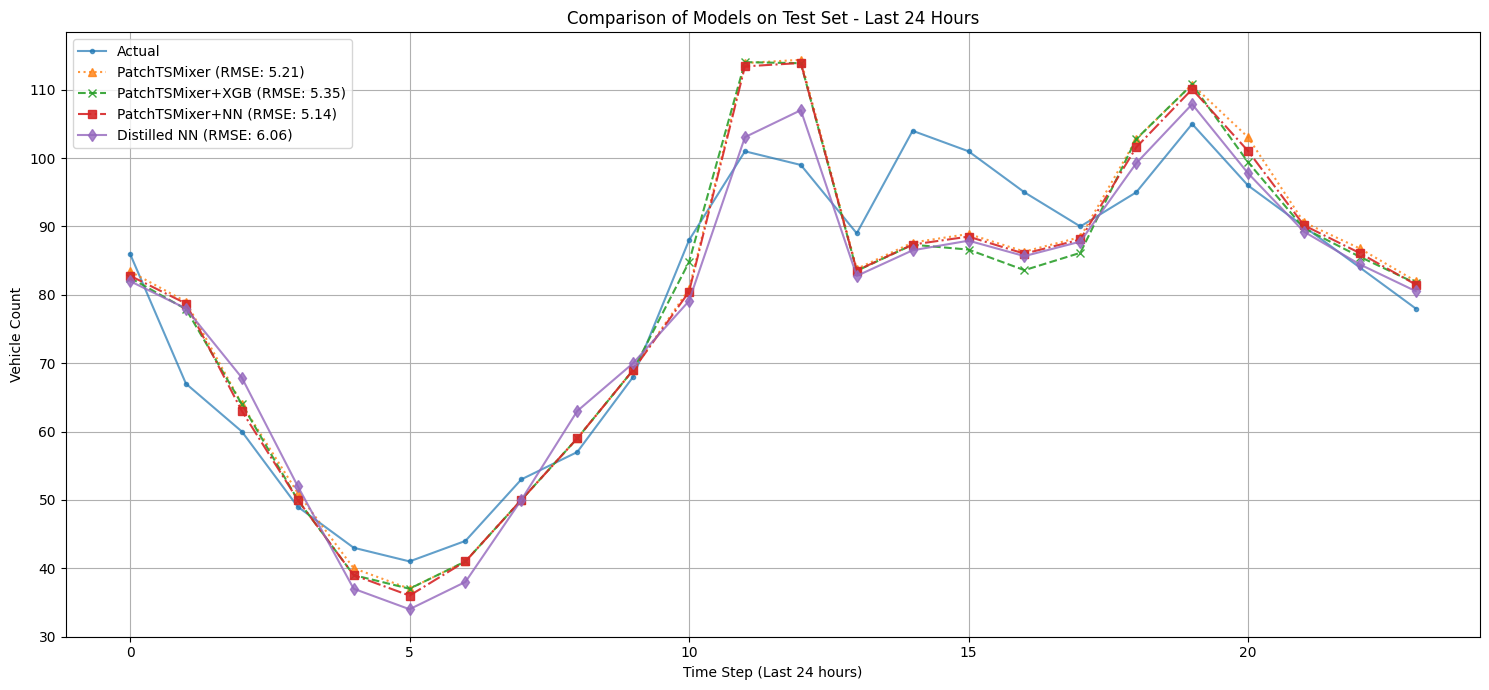

Deleted X_test_refine_tensor.
Cleared CUDA cache.


In [26]:
# === 12. Evaluate Distilled NN Model ===
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

print("\n--- Evaluating Distilled NN Model ---")

# --- Check for necessary variables ---
required_vars_eval = [
    'distilled_nn_model',
    'X_test_refine_tensor',
    'y_test_orig_final',
    'scaler',
    'device',
    'patchtst_rmse', 'patchtst_mae', 'patchtst_test_pred_orig',
    'test_rmse_xgb', 'test_mae_xgb', 'final_test_pred_xgb',
    'test_rmse_nn', 'test_mae_nn', 'final_test_pred_nn'
]

# Placeholders for missing variables
placeholder_value_metric = np.nan
placeholder_value_array = np.array([])
placeholder_model = None
placeholder_scaler = None
placeholder_device = 'cpu'
dummy_data_flag = False

missing_vars_details = {}
for var in required_vars_eval:
    if var not in globals():
        missing_vars_details[var] = f"Missing: '{var}'"
        if 'rmse' in var or 'mae' in var:
            globals()[var] = placeholder_value_metric
        elif 'pred' in var or 'orig_final' in var:
            globals()[var] = placeholder_value_array
        elif 'tensor' in var:
            globals()[var] = torch.tensor([])
        elif 'model' in var:
            globals()[var] = placeholder_model
        elif 'scaler' in var:
            globals()[var] = placeholder_scaler
        elif 'device' in var:
            globals()[var] = placeholder_device

# --- FIX: If X_test_refine_tensor is missing, try to reconstruct it ---
if 'X_test_refine_tensor' not in globals() or globals()['X_test_refine_tensor'].numel() == 0:
    try:
        # Try to reconstruct from X_test_refine_df and all_refinement_features
        if 'X_test_refine_df' in globals() and 'all_refinement_features' in globals() and 'device' in globals():
            X_test_refine_tensor = torch.tensor(
                X_test_refine_df[all_refinement_features].values, dtype=torch.float32
            ).to(device)
            globals()['X_test_refine_tensor'] = X_test_refine_tensor
            print("Reconstructed X_test_refine_tensor from DataFrame.")
        else:
            print("Could not reconstruct X_test_refine_tensor: missing DataFrame or feature list.")
    except Exception as e:
        print(f"Failed to reconstruct X_test_refine_tensor: {e}")

# Re-evaluate existence
X_test_refine_tensor_exists = 'X_test_refine_tensor' in globals() and isinstance(globals()['X_test_refine_tensor'], torch.Tensor) and globals()['X_test_refine_tensor'].numel() > 0
distilled_model_exists = 'distilled_nn_model' in globals() and globals()['distilled_nn_model'] is not None
scaler_exists = 'scaler' in globals() and globals()['scaler'] is not None
targets_exist = 'y_test_orig_final' in globals() and isinstance(globals()['y_test_orig_final'], np.ndarray) and globals()['y_test_orig_final'].size > 0
device_exists = 'device' in globals()

distilled_test_pred_scaled = np.array([])
distilled_test_pred_orig = np.array([])

if not targets_exist:
    warnings.warn("'y_test_orig_final' not found. Creating dummy data for plotting.")
    globals()['y_test_orig_final'] = np.abs(np.random.randn(200) * 10 + 50)
    targets_exist = True
    dummy_data_flag = True

if distilled_model_exists and X_test_refine_tensor_exists and device_exists:
    print("Distilled model and test input tensor found. Attempting prediction.")
    current_device = globals()['device']
    try:
        _ = torch.device(current_device)
    except RuntimeError:
        warnings.warn(f"Invalid device '{current_device}' found. Defaulting to CPU.")
        current_device = 'cpu'
        globals()['device'] = current_device

    distilled_nn_model.eval()
    with torch.no_grad():
        try:
            outputs = distilled_nn_model(X_test_refine_tensor.to(current_device))
            distilled_test_pred_scaled = outputs.squeeze().cpu().numpy()
            if distilled_test_pred_scaled.ndim > 1 and distilled_test_pred_scaled.shape[1] == 1:
                distilled_test_pred_scaled = distilled_test_pred_scaled.flatten()
            elif distilled_test_pred_scaled.ndim == 0:
                distilled_test_pred_scaled = np.array([distilled_test_pred_scaled.item()])
            elif distilled_test_pred_scaled.ndim != 1:
                print(f"Warning: Unexpected prediction shape after processing: {distilled_test_pred_scaled.shape}. Attempting to flatten.")
                distilled_test_pred_scaled = distilled_test_pred_scaled.flatten()
            print(f"Distilled NN predictions generated. Shape: {distilled_test_pred_scaled.shape}")
        except Exception as pred_e:
            print(f"Error during prediction: {pred_e}")
            distilled_test_pred_scaled = np.array([])

    # --- Inverse Transform and Calculate Metrics ---
    if distilled_test_pred_scaled.size > 0 and scaler_exists and targets_exist and not dummy_data_flag:
        print("Attempting inverse transform and metrics calculation.")
        try:
            distilled_test_pred_orig = scaler.inverse_transform(distilled_test_pred_scaled.reshape(-1, 1)).flatten()
            distilled_test_pred_orig = np.clip(distilled_test_pred_orig, 0, None)
            if len(y_test_orig_final) == len(distilled_test_pred_orig):
                distilled_rmse = np.sqrt(mean_squared_error(y_test_orig_final, distilled_test_pred_orig))
                distilled_mae = mean_absolute_error(y_test_orig_final, distilled_test_pred_orig)
                globals()['distilled_rmse'] = distilled_rmse
                globals()['distilled_mae'] = distilled_mae
                print(f"\nDistilled NN - Test RMSE: {distilled_rmse:.2f}")
                print(f"Distilled NN - Test MAE: {distilled_mae:.2f}")
            else:
                print("Error: Cannot calculate metrics. Mismatch between prediction length and target length.")
                globals()['distilled_rmse'] = placeholder_value_metric
                globals()['distilled_mae'] = placeholder_value_metric
        except Exception as eval_e:
            print(f"Error during inverse transform or metrics calculation: {eval_e}")
            globals()['distilled_rmse'] = placeholder_value_metric
            globals()['distilled_mae'] = placeholder_value_metric
    elif not scaler_exists:
        print("Skipping inverse transform and metrics: 'scaler' is missing.")
    elif dummy_data_flag:
        print("Skipping metrics calculation: Using dummy target data.")
    elif distilled_test_pred_scaled.size == 0:
        print("Skipping inverse transform and metrics: Distilled predictions were not generated.")
else:
    print("\nSkipping evaluation prediction step: Distilled model, input tensor, or device not found or invalid.")
    globals()['distilled_rmse'] = placeholder_value_metric
    globals()['distilled_mae'] = placeholder_value_metric

# --- Plot Comparison Table ---
print("\n--- Comparison Table ---")
try:
    patchtsmixer_rmse_val = globals().get('patchtst_rmse', placeholder_value_metric)
    patchtsmixer_mae_val = globals().get('patchtst_mae', placeholder_value_metric)
    test_rmse_xgb_val = globals().get('test_rmse_xgb', placeholder_value_metric)
    test_mae_xgb_val = globals().get('test_mae_xgb', placeholder_value_metric)
    test_rmse_nn_val = globals().get('test_rmse_nn', placeholder_value_metric)
    test_mae_nn_val = globals().get('test_mae_nn', placeholder_value_metric)
    distilled_rmse_val = globals().get('distilled_rmse', placeholder_value_metric)
    distilled_mae_val = globals().get('distilled_mae', placeholder_value_metric)
    xgb_rmse_val = test_rmse_xgb_val if test_rmse_xgb_val != float('inf') else np.nan
    xgb_mae_val = test_mae_xgb_val if test_mae_xgb_val != float('inf') else np.nan
    nn_rmse_val = test_rmse_nn_val if test_rmse_nn_val != float('inf') else np.nan
    nn_mae_val = test_mae_nn_val if test_mae_nn_val != float('inf') else np.nan

    comparison_data = {
        'Model': ['PatchTSMixer Only', 'PatchTSMixer + XGBoost', 'PatchTSMixer + NN (Resid)', 'Distilled NN (Mimic XGB)'],
        'RMSE': [patchtsmixer_rmse_val, xgb_rmse_val, nn_rmse_val, distilled_rmse_val],
        'MAE': [patchtsmixer_mae_val, xgb_mae_val, nn_mae_val, distilled_mae_val]
    }
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.sort_values('RMSE').round(2))
except Exception as e:
    print(f"Warning: Error generating comparison table: {e}")

# --- Plot Comparison (last 24 hours) ---
if targets_exist and distilled_test_pred_orig.size > 0:
    print("\nAttempting to plot comparison.")
    try:
        plt.figure(figsize=(15, 7))
        last_24_hours = 24
        current_y_test_orig_final = globals()['y_test_orig_final']
        start_idx = max(0, len(current_y_test_orig_final) - last_24_hours)
        plot_range = range(min(last_24_hours, len(current_y_test_orig_final) - start_idx))
        actual_plot = current_y_test_orig_final[start_idx:]

        plt.plot(plot_range, actual_plot, label='Actual', marker='.', linestyle='-', alpha=0.7)
        patchtst_test_pred_orig_val = globals().get('patchtst_test_pred_orig', placeholder_value_array)
        final_test_pred_xgb_val = globals().get('final_test_pred_xgb', placeholder_value_array)
        final_test_pred_nn_val = globals().get('final_test_pred_nn', placeholder_value_array)

        if len(patchtst_test_pred_orig_val) == len(current_y_test_orig_final):
            plt.plot(plot_range, patchtst_test_pred_orig_val[start_idx:], label=f'PatchTSMixer (RMSE: {patchtsmixer_rmse_val:.2f})', marker='^', linestyle=':', alpha=0.8)
        if len(final_test_pred_xgb_val) == len(current_y_test_orig_final):
            plt.plot(plot_range, final_test_pred_xgb_val[start_idx:], label=f'PatchTSMixer+XGB (RMSE: {xgb_rmse_val:.2f})', marker='x', linestyle='--', alpha=0.9)
        if len(final_test_pred_nn_val) == len(current_y_test_orig_final):
            plt.plot(plot_range, final_test_pred_nn_val[start_idx:], label=f'PatchTSMixer+NN (RMSE: {nn_rmse_val:.2f})', marker='s', linestyle='-.', alpha=0.9)
        if len(distilled_test_pred_orig) == len(current_y_test_orig_final):
            plt.plot(plot_range, distilled_test_pred_orig[start_idx:], label=f'Distilled NN (RMSE: {distilled_rmse_val:.2f})', marker='d', linestyle='-', alpha=0.8)

        plt.title(f'Comparison of Models on Test Set - Last {min(last_24_hours, len(actual_plot))} Hours')
        plt.xlabel(f'Time Step (Last {min(last_24_hours, len(actual_plot))} hours)')
        plt.ylabel('Vehicle Count')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as plot_e:
        print(f"Warning: Could not generate plot: {plot_e}")
else:
    print("Skipping plotting: Target data or distilled predictions not available.")
if distilled_test_pred_orig.size > 0:
    distilled_nn_test_pred_orig = distilled_test_pred_orig
else:
    distilled_nn_test_pred_orig = np.array([])
# --- Clear CUDA cache ---
if torch.cuda.is_available():
    if X_test_refine_tensor_exists:
        try:
            del X_test_refine_tensor
            print("Deleted X_test_refine_tensor.")
        except NameError:
            print("X_test_refine_tensor was not deleted (likely never properly defined).")
    try:
        torch.cuda.empty_cache()
        print("Cleared CUDA cache.")
    except Exception as cache_e:
        print(f"Error clearing CUDA cache: {cache_e}")
elif device_exists and globals()['device'] != 'cpu':
    print("CUDA not available, but device might have been set to CUDA previously. No cache to clear.")
else:
    print("CUDA not available. No cache to clear.")


--- Random 24-Hour Window Predictions (PatchTSMixer Base) ---
Selected random window (aligned indices): 443 to 466
PatchTST Random Window RMSE: 6.11, MAE: 4.14
PatchTST+XGBoost Random Window RMSE: 5.57, MAE: 3.45
PatchTST+NN (Resid) Random Window RMSE: 6.02, MAE: 3.88
Distilled NN (Mimic XGB) Random Window RMSE: 6.55, MAE: 4.63


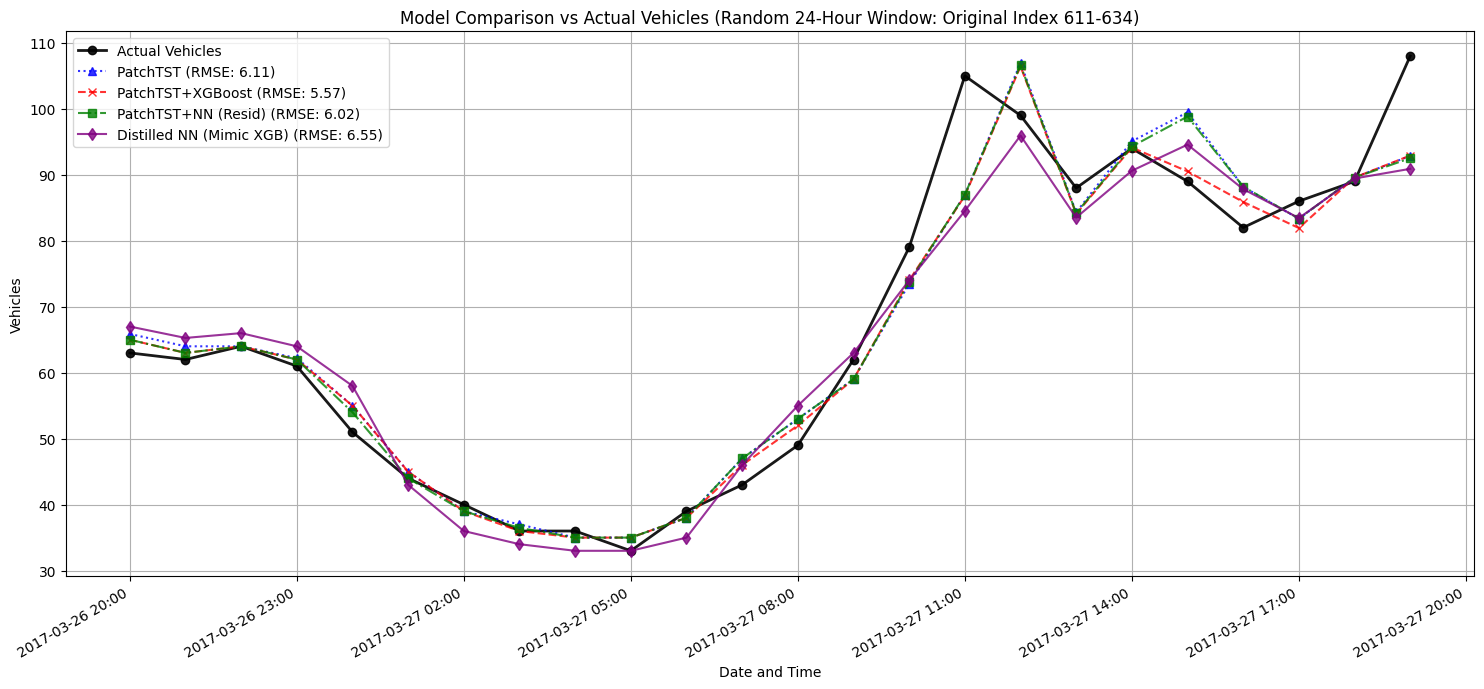

In [28]:
# === Plot Random 24-Hour Window (PatchTSMixer Base) ===
import random
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

print("\n--- Random 24-Hour Window Predictions (PatchTSMixer Base) ---")

context_length = 168

# --- Patch: Use correct PatchTST variable name for base predictions ---
# The correct variable is 'patchtst_test_pred_orig' (not 'patchtsmixer_test_pred_orig')
required_vars_plot = [
    'y_test_orig_final',
    'patchtst_test_pred_orig',      # <-- PATCH: correct variable name
    'final_test_pred_xgb',
    'final_test_pred_nn',
    'distilled_nn_test_pred_orig',
    'test_data_sorted'
]

placeholder_value_array = np.array([])
placeholder_df = pd.DataFrame({'DateTime': pd.to_datetime([])})
plot_possible = True

missing_vars_details = {}
for var in required_vars_plot:
    if var not in globals():
        missing_vars_details[var] = f"Missing: '{var}'"
        plot_possible = False
        if 'pred_orig' in var or 'orig_final' in var:
            globals()[var] = placeholder_value_array
        elif 'test_data_sorted' in var:
            globals()[var] = placeholder_df

if missing_vars_details:
    print("Error: Missing variables required for plotting:")
    for var, msg in missing_vars_details.items():
        print(f"  - {msg}")
    print("Ensure previous evaluation cells for all models ran successfully.")

if plot_possible:
    if not isinstance(globals()['test_data_sorted'], pd.DataFrame) or 'DateTime' not in globals()['test_data_sorted'].columns:
        print("Error: 'test_data_sorted' is not a DataFrame or is missing the 'DateTime' column.")
        plot_possible = False
    elif globals()['y_test_orig_final'].size > 0:
        current_y_test_orig_final = globals()['y_test_orig_final']
        current_test_data_sorted = globals()['test_data_sorted']
        expected_pred_len = len(current_test_data_sorted) - context_length
        mismatched_lengths = False

        if len(current_y_test_orig_final) != expected_pred_len:
            print(f"Error: Length mismatch for y_test_orig_final. Expected {expected_pred_len}, got {len(current_y_test_orig_final)}.")
            mismatched_lengths = True

        for var_name in ['patchtst_test_pred_orig', 'final_test_pred_xgb', 'final_test_pred_nn', 'distilled_nn_test_pred_orig']:
            pred_array = globals().get(var_name, placeholder_value_array)
            if len(pred_array) != expected_pred_len:
                print(f"Warning: Length mismatch for {var_name}. Expected {expected_pred_len}, got {len(pred_array)}. Plotting may be incomplete or fail.")

        if mismatched_lengths:
            plot_possible = False

if plot_possible:
    window_size = 24
    current_y_test_orig_final = globals()['y_test_orig_final']
    current_test_data_sorted = globals()['test_data_sorted']
    aligned_datetimes = current_test_data_sorted['DateTime'].iloc[context_length : context_length + len(current_y_test_orig_final)]
    if len(aligned_datetimes) != len(current_y_test_orig_final):
        print(f"Error: Failed to create aligned DateTime array. Expected length {len(current_y_test_orig_final)}, got {len(aligned_datetimes)}.")
        plot_possible = False

if plot_possible:
    max_start_index = len(current_y_test_orig_final) - window_size
    if max_start_index < 0:
        print(f"Error: Aligned test set length ({len(current_y_test_orig_final)}) is smaller than the window size ({window_size}). Cannot plot window.")
    else:
        random_start_index = random.randint(0, max_start_index)
        end_index = random_start_index + window_size
        window_indices = range(random_start_index, end_index)

        print(f"Selected random window (aligned indices): {random_start_index} to {end_index-1}")

        window_actual = current_y_test_orig_final[window_indices]
        window_patchtst = globals().get('patchtst_test_pred_orig', placeholder_value_array)[window_indices]
        window_xgb = globals().get('final_test_pred_xgb', placeholder_value_array)[window_indices]
        window_nn_resid = globals().get('final_test_pred_nn', placeholder_value_array)[window_indices]
        # --- PATCH: Use patchtst_test_pred_orig as fallback for distilled_nn_test_pred_orig if empty ---
        window_distilled_nn_raw = globals().get('distilled_nn_test_pred_orig', placeholder_value_array)
        if len(window_distilled_nn_raw) == 0 or np.all(np.isnan(window_distilled_nn_raw)):
            print("Warning: 'distilled_nn_test_pred_orig' is empty. Using PatchTST predictions as fallback for this plot.")
            window_distilled_nn = window_patchtst
        else:
            window_distilled_nn = window_distilled_nn_raw[window_indices]
        window_datetimes = aligned_datetimes.iloc[window_indices]

        def calculate_window_metrics(actual, pred):
            if isinstance(pred, np.ndarray) and len(actual) == len(pred) and len(actual) > 0:
                rmse = np.sqrt(mean_squared_error(actual, pred))
                mae = mean_absolute_error(actual, pred)
                return rmse, mae
            return np.nan, np.nan

        patchtst_rmse_window, patchtst_mae_window = calculate_window_metrics(window_actual, window_patchtst)
        xgb_rmse_window, xgb_mae_window = calculate_window_metrics(window_actual, window_xgb)
        nn_resid_rmse_window, nn_resid_mae_window = calculate_window_metrics(window_actual, window_nn_resid)
        distilled_nn_rmse_window, distilled_nn_mae_window = calculate_window_metrics(window_actual, window_distilled_nn)

        print(f"PatchTST Random Window RMSE: {patchtst_rmse_window:.2f}, MAE: {patchtst_mae_window:.2f}")
        print(f"PatchTST+XGBoost Random Window RMSE: {xgb_rmse_window:.2f}, MAE: {xgb_mae_window:.2f}")
        print(f"PatchTST+NN (Resid) Random Window RMSE: {nn_resid_rmse_window:.2f}, MAE: {nn_resid_mae_window:.2f}")
        print(f"Distilled NN (Mimic XGB) Random Window RMSE: {distilled_nn_rmse_window:.2f}, MAE: {distilled_nn_mae_window:.2f}")

        plt.figure(figsize=(15, 7))
        plt.plot(window_datetimes, window_actual, label='Actual Vehicles', marker='o', linestyle='-', linewidth=2, alpha=0.9, color='black')
        model_data = [
            ('PatchTST', window_patchtst, patchtst_rmse_window, patchtst_mae_window, '^', ':', 'blue'),
            ('PatchTST+XGBoost', window_xgb, xgb_rmse_window, xgb_mae_window, 'x', '--', 'red'),
            ('PatchTST+NN (Resid)', window_nn_resid, nn_resid_rmse_window, nn_resid_mae_window, 's', '-.', 'green'),
            ('Distilled NN (Mimic XGB)', window_distilled_nn, distilled_nn_rmse_window, distilled_nn_mae_window, 'd', '-', 'purple')
        ]
        for name, pred, rmse, mae, marker, linestyle, color in model_data:
            if isinstance(pred, np.ndarray) and len(pred) == len(window_actual) and not np.isnan(rmse):
                label = f'{name} (RMSE: {rmse:.2f})'
                plt.plot(window_datetimes, pred, label=label, marker=marker, linestyle=linestyle, alpha=0.8, color=color)
            else:
                print(f"Skipping plot for {name} due to length mismatch or invalid metrics in window.")

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
        plt.gcf().autofmt_xdate()
        original_start_index = random_start_index + context_length
        original_end_index = end_index + context_length
        plt.title(f'Model Comparison vs Actual Vehicles (Random 24-Hour Window: Original Index {original_start_index}-{original_end_index-1})')
        plt.xlabel('Date and Time')
        plt.ylabel('Vehicles')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("\nSkipping random window plot due to missing variables or length/alignment mismatches.")